In [ ]:
# %% [markdown]
# # Autonomous Literature Explorer — PoC Notebook (Headless, No UI)
# 
# This notebook implements the core utilities and the first three PoCs of the blueprint:
# - PoC-0: Infrastructure smoke test
# - PoC-1: Retrieval + ranking quality (hybrid > baselines)
# - PoC-2: PICO gate throughput & silver precision
#
# It also provides reusable modules (BM25, embeddings, ANN, LM client, PubMed/Crossref stubs, gating math, logging)
# that the remaining PoCs will reuse with minimal extra code.
#
# **Operating rules (from the blueprint):**
# - DOI is mandatory for ingestion in PoCs.
# - PubMed/Crossref are the only sources (we stub them below; flip a flag to go live).
# - LLM (Gemma 3n 2B Q4_K_S) is accessed via LM Studio local server or llama-cpp-python.
# - ANN: HNSW (hnswlib) on CPU. BM25: rank-bm25. Hybrid score includes BM25 z, cosine, recency, type boost, novelty.
# - All PoCs are autonomous: they produce artifacts under runs/pocs/.
#
# Hardware target: Windows 11, i7-13700H, RTX 4050 6GB, 32GB RAM.

# %%
# --- Imports & Global Setup ---
import os, sys, re, math, json, time, uuid, shutil, random, sqlite3, pathlib
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional, Tuple, cast
from collections import defaultdict, Counter
from datetime import datetime, timezone
import orjson
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from rapidfuzz import fuzz
from pydantic import BaseModel, Field, ValidationError
from jsonschema import validate as json_validate, Draft202012Validator
from jsonschema.exceptions import SchemaError
import networkx as nx

import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import hnswlib

# LLM backends (choose 1 in config below)
from typing import Literal
LLM_BACKEND = "llama_cpp"   # "lmstudio" or "llama_cpp"

# If LM Studio backend:
LMSTUDIO_BASE_URL = os.getenv("LMSTUDIO_BASE_URL", "http://localhost:1234")
LMSTUDIO_API_KEY  = os.getenv("LMSTUDIO_API_KEY", "lm-studio")
LMSTUDIO_MODEL_ID = os.getenv("LMSTUDIO_MODEL_ID", "gemma-3n-E2B-it-Q4_K_S")  # LM Studio displays the name in UI

# If llama-cpp backend:
LLAMA_CPP_MODEL_PATH = r"C:\Users\Galaxy\.cache\lm-studio\models\unsloth\gemma-3n-E2B-it-GGUF\gemma-3n-E2B-it-Q4_K_S.gguf"

# Embedding model (pluggable). Swap later to Qwen3 Embeddings when convenient.
EMB_MODEL_ID = "Qwen/Qwen3-Embedding-0.6B"
EMB_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Paths
ROOT = pathlib.Path(__file__).resolve().parents[1] if "__file__" in globals() else pathlib.Path.cwd().parents[0]
DATA_DIR = ROOT / "data"
RUNS_DIR = ROOT / "runs" / "pocs"
INDICES_DIR = ROOT / "indices"
ANN_DIR = INDICES_DIR / "ann"
BM25_DIR = INDICES_DIR / "bm25"
CACHE_DIR = DATA_DIR / "cache"

for p in [DATA_DIR, RUNS_DIR, INDICES_DIR, ANN_DIR, BM25_DIR, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

SEED = 17
random.seed(SEED)
np.random.seed(SEED)

# %%
# --- Utility: JSON I/O, logging, timers, file helpers ---

def jdump(obj: Any, path: pathlib.Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        f.write(orjson.dumps(obj, option=orjson.OPT_INDENT_2))

def jload(path: pathlib.Path) -> Any:
    with open(path, "rb") as f:
        return orjson.loads(f.read())

def now_utc() -> str:
    return datetime.now(timezone.utc).isoformat(timespec="seconds")

def run_dir(name: str) -> pathlib.Path:
    d = RUNS_DIR / name
    d.mkdir(parents=True, exist_ok=True)
    return d

class Timer:
    def __init__(self, label=""):
        self.label = label
    def __enter__(self):
        self.t0 = time.perf_counter()
        return self
    def __exit__(self, exc_type, exc, tb):
        self.dt = time.perf_counter() - self.t0
        if self.label:
            print(f"[{self.label}] {self.dt:.3f}s")

# %%
# --- Data schema we’ll use across PoCs ---
# Minimal record for a paper: DOI, title, abstract, year, pub_types.
# In PoCs, we assume DOI is present (as per blueprint).

class Paper(BaseModel):
    doi: str
    title: str
    abstract: str
    year: Optional[int] = None
    pub_types: List[str] = Field(default_factory=list)

class Corpus(BaseModel):
    records: List[Paper]

# %%
# --- Tokenization for BM25 ---
# We deliberately keep this simple and deterministic.

TOKEN_RE = re.compile(r"[A-Za-z0-9_]+", re.UNICODE)

def tokenize(text: str) -> List[str]:
    return TOKEN_RE.findall(text.lower())

def paper_text_for_bm25(p: Paper) -> str:
    return f"{p.title}\n{p.abstract or ''}"

# %%
# --- BM25 Index wrapper (rank-bm25) ---
class BM25Index:
    def __init__(self):
        self.corpus_tokens: List[List[str]] = []
        self.bm25: Optional[BM25Okapi] = None
        self.doi_list: List[str] = []

    def build(self, corpus: Corpus):
        self.doi_list = [r.doi for r in corpus.records]
        self.corpus_tokens = [tokenize(paper_text_for_bm25(r)) for r in corpus.records]
        self.bm25 = BM25Okapi(self.corpus_tokens)

    def query(self, q: str, topk: int = 1000) -> List[Tuple[str, float]]:
        assert self.bm25 is not None
        q_tokens = tokenize(q)
        scores = self.bm25.get_scores(q_tokens)
        top_idx = np.argsort(scores)[::-1][:topk]
        return [(self.doi_list[i], float(scores[i])) for i in top_idx]

# %%
# --- Embedding client (SentenceTransformers) ---
class EmbeddingsClient:
    def __init__(self, model_id: str = EMB_MODEL_ID, device: Optional[str] = None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"[Embeddings] Loading {model_id} on {device} …")
        self.model_id = model_id
        self.model = SentenceTransformer(model_id, device=device)
        self.dim = self.model.get_sentence_embedding_dimension()

    @torch.no_grad()
    def encode_docs(self, texts: list[str], batch_size: int = 64, normalize: bool = True) -> np.ndarray:
        # Prefer new API if present
        if hasattr(self.model, "encode_document"):
            out = self.model.encode_document(
                texts,
                batch_size=batch_size,
                normalize_embeddings=normalize,
                convert_to_numpy=True,
                show_progress_bar=False,
            )
        else:
            out = self.model.encode(
                texts,
                batch_size=batch_size,
                normalize_embeddings=normalize,
                convert_to_numpy=True,
                show_progress_bar=False,
            )
        return cast(np.ndarray, out)  # satisfy Pylance

    @torch.no_grad()
    def encode_queries(self, texts: list[str], batch_size: int = 64, normalize: bool = True) -> np.ndarray:
        if hasattr(self.model, "encode_query"):
            out = self.model.encode_query(
                texts,
                batch_size=batch_size,
                normalize_embeddings=normalize,
                convert_to_numpy=True,
                show_progress_bar=False,
            )
        else:
            # Fallback for older ST: prompt-aware encode()
            out = self.model.encode(
                texts,
                batch_size=batch_size,
                normalize_embeddings=normalize,
                convert_to_numpy=True,
                show_progress_bar=False,
                prompt_name="query",  # supported by prompt-enabled models (Qwen3)
            )
        return cast(np.ndarray, out)
# %%
# --- HNSW (hnswlib) wrapper ---
class HNSWIndex:
    def __init__(self, dim: int, space: str = "cosine"):
        if space not in ("l2", "ip", "cosine"):
            raise ValueError(f"Invalid space '{space}'.")
        self.dim = dim
        self.space = space
        self.index: hnswlib.Index | None = None
        self.doc_ids: list[str] = []

    def build(self, embeddings: np.ndarray, ids: list[str], m: int = 32, ef_construction: int = 200):
        self.index = hnswlib.Index(space=self.space, dim=self.dim)
        self.index.init_index(max_elements=len(ids), ef_construction=ef_construction, M=m)
        self.index.add_items(embeddings, np.arange(len(ids)))
        self.index.set_ef(128)
        self.doc_ids = ids

    def query(self, q: np.ndarray, topk: int = 200) -> list[tuple[str, float]]:
        assert self.index is not None
        if q.ndim == 1:
            q = q.reshape(1, -1)
        k = max(1, min(int(topk), len(self.doc_ids)))
        labels, dists = self.index.knn_query(q, k=k)
        sims = 1.0 - dists[0]
        return [(self.doc_ids[i], float(sims[j])) for j, i in enumerate(labels[0])]

    def save(self, path: pathlib.Path):
        assert self.index is not None
        path.parent.mkdir(parents=True, exist_ok=True)
        self.index.save_index(str(path))

    def load(self, path: pathlib.Path):
        idx = hnswlib.Index(space=self.space, dim=self.dim)
        idx.load_index(str(path))
        self.index = idx

# %%
# --- Recency & novelty helpers (blueprint-compliant) ---
def recency_scaled(years: list[int | None], current_year: int | None = None) -> np.ndarray:
    """
    Scale recency to [0,1]: newest → 1.0, older → decay.
    0 years old -> 1.0; >=10 years -> ~0.0 (clipped).
    Unknown year -> 0.5 (neutral).
    """
    if current_year is None:
        current_year = datetime.now(timezone.utc).year
    vals: list[float] = []
    for y in years:
        if y is None:
            vals.append(0.5)  # neutral for unknown year
        else:
            age = max(0, int(current_year) - int(y))
            vals.append(max(0.0, 1.0 - age / 10.0))
    return np.array(vals, dtype=np.float32)

def zscore(arr: np.ndarray) -> np.ndarray:
    mu = float(arr.mean()) if arr.size else 0.0
    sd = float(arr.std()) if arr.size else 1.0
    if sd == 0.0:
        return np.zeros_like(arr)
    return (arr - mu) / sd

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim == 1:
        a = a.reshape(1, -1)
    if b.ndim == 1:
        b = b.reshape(1, -1)
    a = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)
    b = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-12)
    return float((a @ b.T)[0, 0])

# %%
# --- Hybrid score (per blueprint §4.3) ---
def hybrid_score(
    cosine_to_focus: np.ndarray,
    bm25_z: np.ndarray,
    recency: np.ndarray,
    type_boost: np.ndarray,
    novelty: np.ndarray,
    weights=(0.35, 0.25, 0.20, 0.15, 0.05)
) -> np.ndarray:
    w1, w2, w3, w4, w5 = weights
    return w1*cosine_to_focus + w2*bm25_z + w3*recency + w4*type_boost + w5*novelty

# %%
# --- Lightweight “type boost” from pub_types list ---
PRIMARY_HINTS = {"Randomized Controlled Trial", "Clinical Trial", "Trial", "Cohort", "Case-Control"}
SR_HINTS = {"Meta-Analysis", "Systematic Review", "Review"}

def type_boost_from_pubtypes(pub_types: List[List[str]], mode: Literal["primary", "sr"]) -> np.ndarray:
    out = []
    for pt_list in pub_types:
        s = set(pt_list or [])
        if mode == "primary":
            out.append(1.0 if s & PRIMARY_HINTS else 0.2 if s & SR_HINTS else 0.5)
        else:  # SR hunt
            out.append(1.0 if s & SR_HINTS else 0.3 if s & PRIMARY_HINTS else 0.5)
    return np.array(out, dtype=np.float32)

# %%
# --- Focus centroid & novelty distance ---
def centroid(vectors: np.ndarray) -> np.ndarray:
    if vectors.size == 0:
        raise ValueError("Empty vectors for centroid.")
    c = vectors.mean(axis=0)
    return c / (np.linalg.norm(c) + 1e-12)

def novelty_distance(vecs: np.ndarray, accepted_centroid: np.ndarray) -> np.ndarray:
    # novelty = cosine distance from centroid (larger = more novel)
    cs = (vecs @ accepted_centroid) / (np.linalg.norm(vecs, axis=1) + 1e-12)
    return 1.0 - cs

# %%
# --- LLM Client (LM Studio or llama.cpp) ---
class LLMClient:
    def __init__(self, backend: Literal["lmstudio","llama_cpp"] = LLM_BACKEND):
        self.backend = backend
        if backend == "lmstudio":
            ...
        else:
            from llama_cpp import Llama
            print(f"[llama.cpp] Loading {LLAMA_CPP_MODEL_PATH} …")
            self.llm = Llama(
                model_path=LLAMA_CPP_MODEL_PATH,
                n_ctx=8192,           # 8192 is fine for classification
                n_threads=12,   # ~8–12 for your 13700H is good
                n_gpu_layers=-1,  # keep -1; reduce if VRAM is tight
                n_batch=1024,                   # <<< BIGGEST SPEED LEVER (try 256–512)
                # n_threads_batch=LLAMA_CPP_THREADS,  # optional, can help a bit
                use_mmap=True,
                offload_kqv=True,
                flash_attn=True,
                use_mlock=False,
                verbose=False
            )


    def chat(self, system_prompt: str, user_prompt: str, max_tokens: int = 256, temperature: float = 0.2) -> str:
        if self.backend == "lmstudio":
            url = f"{self.base}/v1/chat/completions"
            body = {
                "model": LMSTUDIO_MODEL_ID,
                "messages": [{"role":"system","content":system_prompt},
                             {"role":"user","content":user_prompt}],
                "temperature": temperature,
                "max_tokens": max_tokens,
                "stream": False
            }
            r = requests.post(url, headers=self.headers, json=body, timeout=120)
            r.raise_for_status()
            return r.json()["choices"][0]["message"]["content"]
        else:
            # emulate chat with a single prompt; simple for schema-based outputs
            prompt = f"<|system|>\n{system_prompt}\n<|user|>\n{user_prompt}\n<|assistant|>\n"
            out = self.llm(
                prompt,
                max_tokens=max_tokens,
                temperature=temperature,
                stop=["</s>"],
            )
            return out["choices"][0]["text"]

# %%
# --- PICO-gate prompt & validator (blueprint §14.1) ---
PICO_GATE_SYSTEM = """You classify biomedical abstracts. Output strict JSON per item. No explanations."""
PICO_GATE_USER_TMPL = """For each item, return a JSON array with objects of schema:
{{
  "paper_id": "<doi-or-pmid>",
  "is_primary_on_PICO": "yes|no|uncertain",
  "design_hint": "RCT|cohort|case-control|other|unknown",
  "why_5_words": "<≤7 tokens>"
}}

Target PICO:
P: {P}
I: {I}
C: {C}
O: {O}
S: {S}

Items:
{items_block}

Return ONLY the JSON array.
"""

PICO_GATE_JSON_SCHEMA = {
  "type":"array",
  "items":{
    "type":"object",
    "properties":{
      "paper_id":{"type":"string"},
      "is_primary_on_PICO":{"type":"string","enum":["yes","no","uncertain"]},
      "design_hint":{"type":"string","enum":["RCT","cohort","case-control","other","unknown"]},
      "why_5_words":{"type":"string"}
    },
    "required":["paper_id","is_primary_on_PICO","design_hint","why_5_words"]
  }
}

def validate_pico_gate(json_obj: Any) -> bool:
    try:
        Draft202012Validator(PICO_GATE_JSON_SCHEMA).validate(json_obj)
    except Exception as e:
        return False
    # extra rule: if "yes" → design_hint ≠ "unknown"
    for item in json_obj:
        if item["is_primary_on_PICO"] == "yes" and item["design_hint"] == "unknown":
            return False
        # 7-token limit heuristic
        if len(item["why_5_words"].split()) > 7:
            return False
    return True

def pico_gate_batch(llm: LLMClient, target_pico: Dict[str,str], items: List[Dict[str,str]], max_tokens: int = 512) -> List[Dict[str,Any]]:
    # items: [{"paper_id": doi, "title": ..., "abstract": ...}, ...]
    # Build user prompt
    block_lines = []
    for it in items:
        t = it.get("title","").strip().replace("\n"," ")
        a = it.get("abstract","").strip().replace("\n"," ")
        pid = it.get("paper_id","")
        block_lines.append(f"- {pid} :: {t} || {a}")
    user_prompt = PICO_GATE_USER_TMPL.format(P=target_pico.get("P",""), I=target_pico.get("I",""),
                                             C=target_pico.get("C",""), O=target_pico.get("O",""),
                                             S=target_pico.get("S",""), items_block="\n".join(block_lines))
    raw = llm.chat(PICO_GATE_SYSTEM, user_prompt, max_tokens=max_tokens, temperature=0.1)
    # Try to parse JSON
    def try_parse(s: str) -> Optional[Any]:
        s = s.strip()
        # heuristics: find first '[' and last ']'
        i, j = s.find("["), s.rfind("]")
        if i >= 0 and j >= 0 and j > i:
            s = s[i:j+1]
        try:
            return json.loads(s)
        except:
            try:
                return orjson.loads(s.encode("utf-8", "ignore"))
            except:
                return None

    parsed = try_parse(raw)
    if parsed and validate_pico_gate(parsed):
        return parsed

    # One repair attempt: ask for JSON-only reprint
    repair_prompt = "Your previous output was invalid. Reprint ONLY a valid JSON array that satisfies the given schema. No commentary."
    raw2 = llm.chat(PICO_GATE_SYSTEM, repair_prompt + "\n\n" + user_prompt, max_tokens=max_tokens, temperature=0.0)
    parsed2 = try_parse(raw2)
    if parsed2 and validate_pico_gate(parsed2):
        return parsed2

    raise ValueError("PICO gate: invalid JSON twice.")

# %%
# --- PubMed & Crossref (minimal, DOI-first) ---
# We include live-capable functions, but PoCs can run with an offline CSV.
USE_LIVE_APIS = False  # Flip to True when you want live metadata / references / citers.

PUBMED_EUTILS = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils"
CROSSREF_API  = "https://api.crossref.org/works"

CACHE_DB = str(CACHE_DIR / "ids.sqlite3")
pathlib.Path(CACHE_DB).parent.mkdir(parents=True, exist_ok=True)
_sql_conn = sqlite3.connect(CACHE_DB)
_sql_conn.execute("CREATE TABLE IF NOT EXISTS doi_pmid(doi TEXT PRIMARY KEY, pmid TEXT)")
_sql_conn.commit()

def cache_pmid(doi: str, pmid: Optional[str]):
    _sql_conn.execute("INSERT OR REPLACE INTO doi_pmid(doi, pmid) VALUES(?,?)", (doi.lower(), pmid))
    _sql_conn.commit()

def get_pmid_cached(doi: str) -> Optional[str]:
    cur = _sql_conn.execute("SELECT pmid FROM doi_pmid WHERE doi=?", (doi.lower(),))
    row = cur.fetchone()
    return row[0] if row and row[0] else None

def crossref_get(doi: str) -> dict[str, Any] | None:
    try:
        r = requests.get(f"{CROSSREF_API}/{doi}", timeout=20)
        if r.status_code == 200:
            return r.json()["message"]
    except Exception:
        return None
    return None

def pubmed_pmid_from_doi(doi: str) -> Optional[str]:
    if not USE_LIVE_APIS:
        return None
    cached = get_pmid_cached(doi)
    if cached is not None:
        return cached
    # ESearch by DOI
    params = {"db":"pubmed","term":f"{doi}[doi]","retmode":"json"}
    try:
        r = requests.get(f"{PUBMED_EUTILS}/esearch.fcgi", params=params, timeout=20)
        r.raise_for_status()
        ids = r.json().get("esearchresult",{}).get("idlist",[])
        pmid = ids[0] if ids else None
        cache_pmid(doi, pmid)
        return pmid
    except:
        return None

def pubmed_refs(doi: str) -> List[str]:
    if not USE_LIVE_APIS:
        return []
    pmid = pubmed_pmid_from_doi(doi)
    if not pmid:
        return []
    params = {"dbfrom":"pubmed","linkname":"pubmed_pubmed_refs","id":pmid,"retmode":"json"}
    try:
        r = requests.get(f"{PUBMED_EUTILS}/elink.fcgi", params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        ls = data.get("linksets",[])
        if not ls: return []
        linkset = ls[0].get("linksetdbs",[])
        if not linkset: return []
        ids = [link["Id"] for link in linkset[0].get("links",[])]
        # We’d need to turn PMIDs into DOIs; omitted here for brevity (Crossref + PubMed mapping).
        return ids
    except:
        return []

def pubmed_citers(doi: str) -> List[str]:
    if not USE_LIVE_APIS:
        return []
    pmid = pubmed_pmid_from_doi(doi)
    if not pmid:
        return []
    params = {"dbfrom":"pubmed","linkname":"pubmed_pubmed_citedin","id":pmid,"retmode":"json"}
    try:
        r = requests.get(f"{PUBMED_EUTILS}/elink.fcgi", params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        ls = data.get("linksets",[])
        if not ls: return []
        linkset = ls[0].get("linksetdbs",[])
        if not linkset: return []
        ids = [link["Id"] for link in linkset[0].get("links",[])]
        return ids
    except:
        return []

# %%
# --- Corpus loader: from CSV or JSONL (offline-friendly) ---
# Expected columns: doi,title,abstract,year,pub_types (pub_types may be pipe-joined strings)
def load_corpus_from_csv(path: pathlib.Path) -> Corpus:
    df = pd.read_csv(path)
    recs = []
    for _, row in df.iterrows():
        pts = []
        if isinstance(row.get("pub_types",""), str):
            pts = [p.strip() for p in str(row["pub_types"]).split("|") if p.strip()]
        recs.append(Paper(
            doi=str(row["doi"]).strip(),
            title=str(row.get("title","")).strip(),
            abstract=str(row.get("abstract","")).strip(),
            year=int(row["year"]) if not pd.isna(row.get("year")) else None,
            pub_types=pts
        ))
    return Corpus(records=recs)

# %%
# --- PoC-0: Infrastructure smoke test ---
# Goal: Confirm BM25, Embeddings, HNSW, and ID policy work together.

def run_poc0(corpus: Corpus, query_text: str, run_name: str = "poc0_smoke"):
    outdir = run_dir(run_name)

    # 1) BM25
    with Timer("BM25 build"):
        bm25 = BM25Index()
        bm25.build(corpus)

    with Timer("BM25 query"):
        bm25_top = bm25.query(query_text, topk=200)

    # 2) Embeddings + HNSW
    with Timer("Embeddings encode"):
        emb_client = EmbeddingsClient()
        doc_texts = [paper_text_for_bm25(p) for p in corpus.records]
        doc_vecs = emb_client.encode_docs(doc_texts, batch_size=64, normalize=True)

    c_vec = emb_client.encode_queries([query_text], batch_size=1, normalize=True)[0]
    with Timer("HNSW build"):
        ann = HNSWIndex(dim=doc_vecs.shape[1], space="cosine")
        ann.build(doc_vecs, [r.doi for r in corpus.records], m=32, ef_construction=200)

    with Timer("HNSW query"):
        ann_top = ann.query(c_vec, topk=200)

    # Save artifacts
    artifacts = {
        "timestamp": now_utc(),
        "query": query_text,
        "bm25_top10": bm25_top[:10],
        "ann_top10": ann_top[:10],
        "counts": {"corpus": len(corpus.records), "bm25_scored": len(bm25_top), "ann_scored": len(ann_top)},
    }
    jdump(artifacts, outdir / "smoke_results.json")
    print("✔ PoC-0 complete →", outdir)

# %%
# --- PoC-1: Hybrid > BM25 & Dense alone (hit@k against a seed list) ---
def run_poc1(
    corpus: Corpus,
    query_text: str,
    seed_dois: List[str],            # known on-topic DOIs used only to measure hit@k
    mode: Literal["primary","sr"] = "primary",
    run_name: str = "poc1_hybrid_quality"
):
    outdir = run_dir(run_name)

    # Indices
    bm25 = BM25Index(); bm25.build(corpus)
    emb_client = EmbeddingsClient()
    doc_texts = [paper_text_for_bm25(p) for p in corpus.records]
    doc_vecs = emb_client.encode_docs(doc_texts, batch_size=64, normalize=True)
    ann = HNSWIndex(dim=doc_vecs.shape[1], space="cosine")  # literal string OK
    ann.build(doc_vecs, [r.doi for r in corpus.records], m=32, ef_construction=200)

    # Precompute doc metadata arrays
    dois = [r.doi for r in corpus.records]
    doi_to_idx = {d:i for i,d in enumerate(dois)}
    years = np.array([r.year or None for r in corpus.records])
    pubtypes_list = [r.pub_types for r in corpus.records]

    # Focus centroid: for PoC, use top BM25 as provisional focus (could also use a handpicked set)
    bm25_top = bm25.query(query_text, topk=200)
    focus_dois = [d for d,_ in bm25_top[:20]]
    focus_vecs = doc_vecs[[doi_to_idx[d] for d in focus_dois if d in doi_to_idx]]
    focus_centroid = centroid(focus_vecs)

    # Scores
    q_vec = emb_client.encode_queries([query_text], batch_size=1, normalize=True)[0]
    # Dense-only ranking
    dense_pairs = ann.query(q_vec, topk=min(2000, len(dois)))
    dense_scores_map = {d:s for d,s in dense_pairs}

    # BM25
    bm25_pairs = bm25.query(query_text, topk=min(2000, len(dois)))
    bm25_scores = np.zeros(len(dois), dtype=np.float32)
    for d, s in bm25_pairs:
        bm25_scores[doi_to_idx[d]] = s
    bm25_z = zscore(bm25_scores)

    # Cosine to focus centroid for all docs
    cos_focus = np.zeros(len(dois), dtype=np.float32)
    for d, idx in doi_to_idx.items():
        cos_focus[idx] = cosine_sim(doc_vecs[idx], focus_centroid)

    # Recency
    rec = recency_scaled([r.year for r in corpus.records])

    # Type boost
    tb = type_boost_from_pubtypes(pubtypes_list, mode=mode)

    # Novelty vs centroid
    nov = novelty_distance(doc_vecs, focus_centroid)

    # Hybrid score
    hybrid = hybrid_score(cos_focus, bm25_z, rec, tb, nov)

    # Rank three ways
    kmax = min(1000, len(dois))
    bm25_ranked = [dois[i] for i in np.argsort(bm25_scores)[::-1][:kmax]]
    dense_ranked = [p[0] for p in dense_pairs[:kmax]]
    hybrid_ranked = [dois[i] for i in np.argsort(hybrid)[::-1][:kmax]]

    def hit_at_k(ranked: List[str], seeds: List[str], k: int) -> int:
        topk = set(ranked[:k])
        return sum(1 for s in seeds if s in topk)

    evals = {}
    for k in [50, 100, 200]:
        evals[f"bm25_hit@{k}"] = hit_at_k(bm25_ranked, seed_dois, k)
        evals[f"dense_hit@{k}"] = hit_at_k(dense_ranked, seed_dois, k)
        evals[f"hybrid_hit@{k}"] = hit_at_k(hybrid_ranked, seed_dois, k)

    artifacts = {
        "timestamp": now_utc(),
        "query": query_text,
        "seed_dois": seed_dois,
        "evals": evals,
        "top10": {
            "bm25": bm25_ranked[:10],
            "dense": dense_ranked[:10],
            "hybrid": hybrid_ranked[:10],
        }
    }
    jdump(artifacts, outdir / "hybrid_eval.json")
    print("✔ PoC-1 complete →", outdir, "|", evals)

# %%
# --- PoC-2: PICO gate (batched) throughput & “silver” precision ---
# “Silver” precision = among items labeled yes, % that match PublicationType hint (when present)
def run_poc2(
    corpus: Corpus,
    target_pico: Dict[str,str],
    batch_size: int = 24,
    max_items: int = 240,
    run_name: str = "poc2_pico_gate"
):
    outdir = run_dir(run_name)
    llm = LLMClient(LLM_BACKEND)

    # Take first N ambiguous-ish items (we’ll just take the first N for PoC)
    items = []
    for r in corpus.records[:max_items]:
        items.append({"paper_id": r.doi, "title": r.title, "abstract": r.abstract})

    # Batched calls
    results = []
    t0 = time.perf_counter()
    for i in range(0, len(items), batch_size):
        batch = items[i:i+batch_size]
        preds = pico_gate_batch(llm, target_pico, batch, max_tokens=768)
        results.extend(preds)
    dt = time.perf_counter() - t0
    abstracts_sec = len(items) / max(dt, 1e-6)

    # Silver precision: among "yes", check if PublicationType suggests primary
    yes = [r for r in results if r["is_primary_on_PICO"] == "yes"]
    y_dois = set([r["paper_id"] for r in yes])
    # PublicationType heuristic
    silver_hits = 0; silver_total = 0
    for p in corpus.records:
        if p.doi in y_dois:
            silver_total += 1
            if set(p.pub_types) & PRIMARY_HINTS:
                silver_hits += 1
    silver_precision = (silver_hits / silver_total) if silver_total else None

    artifacts = {
        "timestamp": now_utc(),
        "target_pico": target_pico,
        "counts": {"batched": len(items), "batch_size": batch_size},
        "throughput_abstracts_per_sec": abstracts_sec,
        "silver_precision_yes_pubtype_primary": silver_precision,
        "sample_outputs": results[:10],
    }
    jdump(artifacts, outdir / "pico_gate_metrics.json")
    print(f"✔ PoC-2 complete → {outdir} | throughput ≈ {abstracts_sec:.1f} abs/s | silver precision={silver_precision}")

# %%
# --- Convenience: tiny synthetic corpus for first runs (replace with your real CSV) ---
def make_tiny_corpus() -> Corpus:
    # A few biomedical dummy entries (DOIs are fake placeholders except where recognizable)
    rows = [
        {"doi":"10.1000/alpha1", "title":"Randomized trial of drug X for hypertension",
         "abstract":"We conducted a randomized controlled trial comparing drug X vs placebo in adult hypertension.",
         "year":2022, "pub_types":"Randomized Controlled Trial"},
        {"doi":"10.1000/alpha2", "title":"Observational cohort of drug X adherence",
         "abstract":"Cohort study examining adherence to drug X and blood pressure outcomes.",
         "year":2021, "pub_types":"Cohort"},
        {"doi":"10.1000/alpha3", "title":"Systematic review of antihypertensive therapies",
         "abstract":"We synthesized RCTs on antihypertensive drugs and assessed outcomes.",
         "year":2023, "pub_types":"Systematic Review|Meta-Analysis"},
        {"doi":"10.1000/alpha4", "title":"Case-control on salt intake and hypertension",
         "abstract":"Case-control study exploring dietary salt association with hypertension.",
         "year":2019, "pub_types":"Case-Control"},
        {"doi":"10.1000/alpha5", "title":"Trial of drug Y vs drug X",
         "abstract":"Randomized head-to-head trial comparing drug Y vs drug X on systolic BP reduction.",
         "year":2024, "pub_types":"Randomized Controlled Trial"},
        {"doi":"10.1000/alpha6", "title":"Narrative review on hypertension pathophysiology",
         "abstract":"Narrative review of molecular mechanisms in blood pressure regulation.",
         "year":2018, "pub_types":"Review"},
        {"doi":"10.1000/alpha7", "title":"Effect of drug X on renal outcomes in hypertensive diabetics",
         "abstract":"Prospective study with secondary renal endpoints for drug X.",
         "year":2020, "pub_types":"Clinical Trial"}
    ]
    recs = []
    for r in rows:
        recs.append(Paper(
            doi=r["doi"], title=r["title"], abstract=r["abstract"],
            year=r["year"], pub_types=[p.strip() for p in r["pub_types"].split("|")]
        ))
    return Corpus(records=recs)

# %%
# --- RUN: sanity with the tiny corpus ---
if __name__ == "__main__":
    # If you have a real CSV, swap here:
    # corpus = load_corpus_from_csv(ROOT / "data" / "seed" / "your_corpus.csv")
    corpus = make_tiny_corpus()

    print(f"Corpus size: {len(corpus.records)}")
    query = ""  #"adult hypertension randomized trial drug X"

    # PoC-0
    run_poc0(corpus, query_text=query, run_name="poc0_smoke")

    # PoC-1
    seed_dois = ["10.1000/alpha1", "10.1000/alpha5"]  # the “on-topic” set for evaluation
    run_poc1(corpus, query_text=query, seed_dois=seed_dois, mode="primary", run_name="poc1_hybrid_quality")

    # PoC-2
    target_pico = {
        "P": "Adults with primary hypertension",
        "I": "Drug X",
        "C": "Placebo or Drug Y",
        "O": "Systolic blood pressure reduction",
        "S": "Randomized controlled trials prioritized"
    }
    run_poc2(corpus, target_pico=target_pico, batch_size=24, max_items=96, run_name="poc2_pico_gate")


Corpus size: 7
[BM25 build] 0.000s
[BM25 query] 0.000s
[Embeddings] Loading Qwen/Qwen3-Embedding-0.6B on cuda …
[Embeddings encode] 7.399s
[HNSW build] 0.001s
[HNSW query] 0.000s
✔ PoC-0 complete → c:\Users\Galaxy\LEVI\projects\Python\research_agent\runs\pocs\poc0_smoke
[Embeddings] Loading Qwen/Qwen3-Embedding-0.6B on cuda …
✔ PoC-1 complete → c:\Users\Galaxy\LEVI\projects\Python\research_agent\runs\pocs\poc1_hybrid_quality | {'bm25_hit@50': 2, 'dense_hit@50': 2, 'hybrid_hit@50': 2, 'bm25_hit@100': 2, 'dense_hit@100': 2, 'hybrid_hit@100': 2, 'bm25_hit@200': 2, 'dense_hit@200': 2, 'hybrid_hit@200': 2}
[llama.cpp] Loading C:\Users\Galaxy\.cache\lm-studio\models\unsloth\gemma-3n-E2B-it-GGUF\gemma-3n-E2B-it-Q4_K_S.gguf …


llama_context: n_ctx_per_seq (8192) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
llama_kv_cache_unified_iswa: using full-size SWA cache (ref: https://github.com/ggml-org/llama.cpp/pull/13194#issuecomment-2868343055)


✔ PoC-2 complete → c:\Users\Galaxy\LEVI\projects\Python\research_agent\runs\pocs\poc2_pico_gate | throughput ≈ 0.2 abs/s | silver precision=1.0


In [ ]:
##pytorch-cuda sanity check
# Torch print (Pylance-safe)
import torch
cuda_str = getattr(getattr(torch, "version", None), "cuda", None)
print("torch:", torch.__version__, "| cuda:", cuda_str, "| gpu?", torch.cuda.is_available())

# Recency function
from datetime import datetime, timezone
import numpy as np
print(recency_scaled([2025, 2020, None, 2015]).tolist())

# HNSW build/query minimal smoke
import hnswlib
dim = 8
vecs = np.random.randn(10, dim).astype("float32")
vecs /= np.linalg.norm(vecs, axis=1, keepdims=True) + 1e-12
ann = HNSWIndex(dim=dim, space="cosine")
ann.build(vecs, ids=[f"id{i}" for i in range(10)], m=16, ef_construction=100)
q = vecs[0]
print(ann.query(q, topk=3))

In [1]:
##llamma cpp sanity check
import llama_cpp
print(llama_cpp.llama_print_system_info().decode())


CPU : SSE3 = 1 | SSSE3 = 1 | AVX = 1 | AVX2 = 1 | F16C = 1 | FMA = 1 | LLAMAFILE = 1 | OPENMP = 1 | REPACK = 1 | 


In [1]:
#higiene de vram (por algum motivo as embeddings(?) ficam carregadas após o fim do poc)
# after you finish embeddings work:
emb_client = None   # or: del emb_client
import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


In [3]:
# Single-cell PoC (redo): PubMed → LM Studio /v1/embeddings with warmup, timeouts, auto-batch fallback
import requests, time, json, math, statistics, xml.etree.ElementTree as ET
from typing import List, Tuple

# -------------------- CONFIG YOU MAY TUNE --------------------
LMSTUDIO_BASE      = "http://localhost:1234"
LMSTUDIO_API_KEY   = "lm-studio"  # change if you set a custom key in LM Studio
EMB_MODEL_ID       = "text-embedding-qwen3-embedding-0.6b"  # pick exactly from /v1/models
CHAT_MODEL_ID      = "gemma-3n-e4b-it"                      # not required; used for optional sanity ping

QUERY              = "hypertension randomized controlled trial"
N_RESULTS          = 200      # PubMed results to fetch
ABS_TRUNC_CHARS    = 2000     # tighter truncation improves speed; embeddings rarely need more
INITIAL_BATCH_SIZE = 32       # start conservative; auto-reduces on timeout
MIN_BATCH_SIZE     = 8        # don't go below this
INITIAL_TIMEOUT    = 300      # generous first-batch timeout (handles JIT model load)
PER_BATCH_TIMEOUT  = 120      # subsequent batches
MAX_RETRIES        = 2        # retries per batch (on timeout only)

# -------------------- LOW-LEVEL HELPERS --------------------
def _headers():
    return {"Content-Type":"application/json", "Authorization": f"Bearer {LMSTUDIO_API_KEY}"}

def list_models():
    try:
        r = requests.get(f"{LMSTUDIO_BASE}/v1/models", timeout=30)
        r.raise_for_status()
        data = r.json().get("data", [])
        return [m.get("id") for m in data]
    except Exception as e:
        print(f"[warn] /v1/models failed: {e}")
        return []

def chat_ping():
    """Optional: confirm chat path works."""
    url = f"{LMSTUDIO_BASE}/v1/chat/completions"
    body = {
        "model": CHAT_MODEL_ID,
        "messages": [
            {"role":"system","content":"Answer 'pong'"},
            {"role":"user","content":"ping"}
        ],
        "temperature": 0.0,
        "max_tokens": 8,
        "stream": False
    }
    try:
        r = requests.post(url, headers=_headers(), data=json.dumps(body), timeout=30)
        r.raise_for_status()
        print("[chat] sanity:", r.json()["choices"][0]["message"]["content"])
    except Exception as e:
        print("[warn] chat sanity failed:", e)

# -------------------- PUBMED (live) --------------------
def pubmed_esearch(term: str, retmax: int) -> List[str]:
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        params={"db":"pubmed","term":term,"retmode":"json","retmax":int(retmax)},
        timeout=60,
    )
    r.raise_for_status()
    return r.json().get("esearchresult", {}).get("idlist", [])

def pubmed_efetch(pmids: List[str]) -> List[dict]:
    if not pmids: return []
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        params={"db":"pubmed","id":",".join(pmids),"retmode":"xml"},
        timeout=120,
    )
    r.raise_for_status()
    root = ET.fromstring(r.text)
    out = []
    for article in root.findall(".//PubmedArticle"):
        art = article.find(".//Article")
        if art is None: continue
        t_el = art.find("./ArticleTitle");      title = "".join(t_el.itertext()).strip() if t_el is not None else ""
        abst = " ".join("".join(ab.itertext()) for ab in art.findall("./Abstract/AbstractText")).strip()
        pmid = (article.findtext(".//PMID") or "").strip()
        # try DOI
        doi = None
        for aid in article.findall(".//ArticleIdList/ArticleId"):
            if aid.get("IdType") == "doi" and aid.text:
                doi = aid.text.strip(); break
        out.append({"pmid": pmid, "doi": doi or "", "title": title, "abstract": abst})
    return out

def build_texts(records: List[dict], trunc_chars: int) -> Tuple[List[str], List[str]]:
    texts, ids = [], []
    for rec in records:
        title = rec.get("title") or ""
        abstract = (rec.get("abstract") or "")[:trunc_chars]
        txt = (title + "\n" + abstract).strip()
        if not txt: continue
        texts.append(txt)
        ids.append(rec.get("pmid") or rec.get("doi") or "")
    return texts, ids

# -------------------- EMBEDDINGS VIA LM STUDIO --------------------
def embed_batch(batch_texts: List[str], model_id: str, timeout_s: int) -> List[List[float]]:
    url = f"{LMSTUDIO_BASE}/v1/embeddings"
    body = {"model": model_id, "input": batch_texts}
    r = requests.post(url, headers=_headers(), data=json.dumps(body), timeout=timeout_s)
    r.raise_for_status()
    obj = r.json()
    data = obj.get("data", [])
    if len(data) != len(batch_texts):
        raise RuntimeError(f"Embedding mismatch: got {len(data)} for batch size {len(batch_texts)}")
    return [item["embedding"] for item in data]

def embed_all(texts: List[str], model_id: str,
              init_batch: int, min_batch: int,
              init_timeout: int, per_timeout: int, max_retries: int):
    n = len(texts)
    all_vecs: List[List[float]] = []
    per_batch_s = []
    batch = init_batch
    idx = 0

    # ---- WARMUP: 1 small request to trigger JIT load (longer timeout) ----
    warm_txt = [texts[0]] if n else []
    if warm_txt:
        t0 = time.perf_counter()
        try:
            _ = embed_batch(warm_txt, model_id, timeout_s=init_timeout)
            t1 = time.perf_counter() - t0
            print(f"[warmup] 1 item in {t1:.1f}s (JIT load + first run)")
            all_vecs.extend(_)
            per_batch_s.append(t1)
            idx = 1
        except requests.Timeout:
            raise RuntimeError("Warmup timed out. Increase INITIAL_TIMEOUT or pre-load the embedding model in LM Studio.")
        except Exception as e:
            raise

    # ---- MAIN LOOP ----
    t_total0 = time.perf_counter()
    batch_times = []
    while idx < n:
        end = min(n, idx + batch)
        subset = texts[idx:end]

        # retry with backoff / batch shrinking on timeout
        attempt = 0
        timeout_s = per_timeout
        while True:
            t0 = time.perf_counter()
            try:
                vecs = embed_batch(subset, model_id, timeout_s=timeout_s)
                dt = time.perf_counter() - t0
                all_vecs.extend(vecs)
                batch_times.append(dt)
                per_batch_s.append(dt)
                print(f"[batch ok] {idx}-{end-1} | size={len(subset)} | {dt:.1f}s")
                idx = end
                break
            except requests.Timeout:
                attempt += 1
                print(f"[timeout] batch {idx}-{end-1} (size={len(subset)}), attempt {attempt}/{max_retries}")
                if attempt >= max_retries and batch <= min_batch:
                    raise RuntimeError("Repeated timeouts even at min batch; consider shorter inputs or higher timeout.")
                # back off: shrink batch or raise timeout
                if batch > min_batch:
                    batch = max(min_batch, batch // 2)
                    end = min(n, idx + batch)
                    subset = texts[idx:end]
                    print(f"         reducing batch to {batch}")
                else:
                    timeout_s = int(timeout_s * 1.5)  # last resort: increase timeout a bit
                    print(f"         increasing timeout to {timeout_s}s")
            except Exception as e:
                raise

    t_total = time.perf_counter() - t_total0
    # ---- Metrics ----
    count = len(all_vecs)
    dim = (len(all_vecs[0]) if count else 0)
    ips  = (count / t_total) if t_total > 0 else float("inf")
    p50  = statistics.median(batch_times) if batch_times else None
    p95  = (sorted(batch_times)[int(0.95*len(batch_times))-1] if batch_times else None)
    stats = {
        "count": count,
        "dim": dim,
        "total_time_s": t_total,
        "items_per_sec": ips,
        "batches": len(batch_times) + (1 if warm_txt else 0),
        "median_batch_time_s": p50,
        "p95_batch_time_s": p95,
        "final_batch_size": batch
    }
    return all_vecs, stats

# -------------------- RUN --------------------
print("=== Models on LM Studio ===")
for mid in list_models():
    print(" -", mid)

print("\n=== Optional chat sanity ===")
chat_ping()

print("\n=== PubMed ===")
t0 = time.perf_counter()
pmids = pubmed_esearch(QUERY, N_RESULTS)
print(f"esearch: {len(pmids)} PMIDs")
recs  = pubmed_efetch(pmids)
t_fetch = time.perf_counter() - t0
print(f"efetch+parse: {len(recs)} records in {t_fetch:.2f}s")

texts, ids = build_texts(recs, ABS_TRUNC_CHARS)
print(f"texts ready: {len(texts)} | trunc={ABS_TRUNC_CHARS} chars")

print("\n=== Embeddings via LM Studio (warmup + robust batches) ===")
try:
    t0 = time.perf_counter()
    vecs, stats = embed_all(
        texts,
        EMB_MODEL_ID,
        init_batch=INITIAL_BATCH_SIZE,
        min_batch=MIN_BATCH_SIZE,
        init_timeout=INITIAL_TIMEOUT,
        per_timeout=PER_BATCH_TIMEOUT,
        max_retries=MAX_RETRIES
    )
    t1 = time.perf_counter() - t0
    print("\n---- Embedding Stats ----")
    for k, v in stats.items():
        print(f"{k}: {v}")
    if stats["count"] > 0:
        print(f"first vector dim: {len(vecs[0])}")
        print(f"first 8 dims: {vecs[0][:8]}")
except Exception as e:
    print("[fatal] embedding run failed:", e)
    print("Tip: pre-load the embedding model in LM Studio (so JIT load doesn't eat your first timeout), "
          "reduce INITIAL_BATCH_SIZE, or increase INITIAL_TIMEOUT/PER_BATCH_TIMEOUT.")

print("\n=== Summary ===")
print(f"Query: {QUERY!r}")
print(f"Fetched: {len(recs)} | Embedded: {len(texts)}")
if 'stats' in locals():
    print(f"Throughput: {stats['items_per_sec']:.2f} items/s | Total embed time: {stats['total_time_s']:.1f}s")
print("Done.")


=== Models on LM Studio ===
 - gemma-3n-e4b-it
 - text-embedding-qwen3-embedding-0.6b
 - text-embedding-qwen3-embedding-4b
 - text-embedding-nomic-embed-text-v1.5
 - gemma-3n-e2b-it
 - gemma-3-4b-it-qat
 - qwen3-4b
 - qwen3-1.7b
 - llama-3.2-3b-instruct
 - llama-3.2-1b-instruct

=== Optional chat sanity ===
[warn] chat sanity failed: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=30)

=== PubMed ===
esearch: 200 PMIDs
efetch+parse: 200 records in 2.48s
texts ready: 200 | trunc=2000 chars

=== Embeddings via LM Studio (warmup + robust batches) ===
[warmup] 1 item in 215.7s (JIT load + first run)
[batch ok] 1-32 | size=32 | 15.7s
[batch ok] 33-64 | size=32 | 9.5s
[batch ok] 65-96 | size=32 | 10.3s
[batch ok] 97-128 | size=32 | 9.8s
[batch ok] 129-160 | size=32 | 10.3s
[batch ok] 161-192 | size=32 | 9.8s
[batch ok] 193-199 | size=7 | 4.3s

---- Embedding Stats ----
count: 200
dim: 1024
total_time_s: 69.51629600021988
items_per_sec: 2.877023252207905
batches

In [4]:
# Single-cell PoC: PubMed → LM Studio /v1/embeddings → cosine quality check
# - Runs TWO embedding modes: (A) title only, (B) title+abstract
# - Computes cosine sims (via unit-normalized dot products)
# - Randomly samples 10 items and prints their MOST and LEAST similar neighbors for each mode
# - No files, no paths; robust to JIT model loading; adjustable batch sizes/timeouts
#
# Assumptions:
#   • LM Studio server running at http://localhost:1234 with API key "lm-studio" (change below if needed)
#   • An embedding model is available in LM Studio, e.g. "text-embedding-qwen3-embedding-0.6b"
#   • Context window in LM Studio is 8096 for all models (we still truncate abstracts sensibly)
#
# You can tune:
#   • QUERY, N_RESULTS
#   • ABS_TRUNC_CHARS (for title+abstract mode)
#   • INITIAL_BATCH_SIZE, MIN_BATCH_SIZE
#   • INITIAL_TIMEOUT (warmup), PER_BATCH_TIMEOUT (subsequent batches)

import requests, time, json, math, statistics, random, xml.etree.ElementTree as ET
import numpy as np
from typing import List, Tuple

# -------------------- CONFIG --------------------
LMSTUDIO_BASE      = "http://localhost:1234"
LMSTUDIO_API_KEY   = "lm-studio"
EMB_MODEL_ID       = "text-embedding-qwen3-embedding-0.6b"   # confirm via /v1/models
QUERY              = "hypertension randomized controlled trial"
N_RESULTS          = 200

# Embedding input shaping
ABS_TRUNC_CHARS    = 2000      # title+abstract truncation; 8096-token window is large, but embeddings rarely need very long text
TITLE_ONLY         = True       # keep True (we'll always run title-only + title+abstract)

# Batching & timeouts
INITIAL_BATCH_SIZE = 32         # safe start for 6 GB VRAM; raise to 48/64 after confirming stability
MIN_BATCH_SIZE     = 8
INITIAL_TIMEOUT    = 300        # warmup (first call) to absorb JIT model load
PER_BATCH_TIMEOUT  = 120        # typical per-batch timeout after warmup
MAX_RETRIES        = 2          # per-batch retries on timeout

# Sampling & display
RAND_SEED          = 17
SAMPLE_K           = 10         # how many random query items to sample for reporting
SHOW_ABS_PREVIEW   = 180        # characters of abstract to preview in printouts

# -------------------- UTIL --------------------
def _headers():
    return {"Content-Type":"application/json", "Authorization": f"Bearer {LMSTUDIO_API_KEY}"}

def list_models():
    try:
        r = requests.get(f"{LMSTUDIO_BASE}/v1/models", timeout=30)
        r.raise_for_status()
        return [m.get("id") for m in r.json().get("data", [])]
    except Exception as e:
        print(f"[warn] /v1/models failed: {e}")
        return []

# -------------------- PUBMED --------------------
def pubmed_esearch(term: str, retmax: int) -> List[str]:
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        params={"db":"pubmed","term":term,"retmode":"json","retmax":int(retmax)},
        timeout=60,
    )
    r.raise_for_status()
    return r.json().get("esearchresult", {}).get("idlist", [])

def pubmed_efetch(pmids: List[str]) -> List[dict]:
    if not pmids: return []
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        params={"db":"pubmed","id":",".join(pmids),"retmode":"xml"},
        timeout=120,
    )
    r.raise_for_status()
    root = ET.fromstring(r.text)
    out = []
    for article in root.findall(".//PubmedArticle"):
        art = article.find(".//Article")
        if art is None: continue
        t_el = art.find("./ArticleTitle")
        title = "".join(t_el.itertext()).strip() if t_el is not None else ""
        abst = " ".join("".join(ab.itertext()) for ab in art.findall("./Abstract/AbstractText")).strip()
        pmid = (article.findtext(".//PMID") or "").strip()
        doi = None
        for aid in article.findall(".//ArticleIdList/ArticleId"):
            if aid.get("IdType") == "doi" and aid.text:
                doi = aid.text.strip(); break
        out.append({"pmid": pmid, "doi": doi or "", "title": title, "abstract": abst})
    return out

def build_texts(records: List[dict], mode: str, trunc_chars: int) -> Tuple[List[str], List[str], List[str], List[str]]:
    """
    mode in {"title", "title+abstract"}
    Returns: texts, ids, titles, abstracts
    """
    texts, ids, titles, abstracts = [], [], [], []
    for rec in records:
        title = (rec.get("title") or "").strip()
        abstract = (rec.get("abstract") or "").strip()
        pid = rec.get("pmid") or rec.get("doi") or ""
        if mode == "title":
            txt = title
        else:
            txt = (title + ("\n" + abstract[:trunc_chars] if abstract else "")).strip()
        if not txt:
            continue
        texts.append(txt)
        ids.append(pid)
        titles.append(title)
        abstracts.append(abstract)
    return texts, ids, titles, abstracts

# -------------------- EMBEDDINGS (LM Studio) --------------------
def embed_batch(batch_texts: List[str], model_id: str, timeout_s: int) -> List[List[float]]:
    url = f"{LMSTUDIO_BASE}/v1/embeddings"
    body = {"model": model_id, "input": batch_texts}
    r = requests.post(url, headers=_headers(), data=json.dumps(body), timeout=timeout_s)
    r.raise_for_status()
    obj = r.json()
    data = obj.get("data", [])
    if len(data) != len(batch_texts):
        raise RuntimeError(f"Embedding mismatch: got {len(data)} for batch size {len(batch_texts)}")
    return [item["embedding"] for item in data]

def embed_all(texts: List[str], model_id: str,
              init_batch: int, min_batch: int,
              init_timeout: int, per_timeout: int, max_retries: int):
    """
    Warmup + batched embedding with timeout-aware batch fallback.
    Returns (np.ndarray [N,D], stats_dict).
    """
    n = len(texts)
    if n == 0:
        return np.zeros((0,0), dtype=np.float32), {"count":0,"dim":0,"items_per_sec":None,"total_time_s":0}

    vecs = []
    per_batch_s = []
    batch = init_batch
    idx = 0

    # Warmup (1 item) to trigger JIT model load
    warm_txt = [texts[0]]
    t0 = time.perf_counter()
    _ = embed_batch(warm_txt, model_id, timeout_s=init_timeout)
    warm_dt = time.perf_counter() - t0
    vecs.extend(_)
    per_batch_s.append(warm_dt)
    idx = 1
    print(f"[warmup] {model_id}: 1 item in {warm_dt:.1f}s")

    # Main loop
    t_total0 = time.perf_counter()
    batch_times = []
    while idx < n:
        end = min(n, idx + batch)
        subset = texts[idx:end]

        attempt = 0
        timeout_s = per_timeout
        while True:
            t0 = time.perf_counter()
            try:
                v = embed_batch(subset, model_id, timeout_s=timeout_s)
                dt = time.perf_counter() - t0
                vecs.extend(v)
                batch_times.append(dt)
                per_batch_s.append(dt)
                print(f"[batch ok] {idx}-{end-1} | size={len(subset)} | {dt:.1f}s")
                idx = end
                break
            except requests.Timeout:
                attempt += 1
                print(f"[timeout] {idx}-{end-1} (size={len(subset)}) attempt {attempt}/{max_retries}")
                if attempt >= max_retries and batch <= min_batch:
                    raise RuntimeError("Repeated timeouts at min batch; shorten inputs or raise timeouts.")
                if batch > min_batch:
                    batch = max(min_batch, batch // 2)
                    end = min(n, idx + batch)
                    subset = texts[idx:end]
                    print(f"         reducing batch to {batch}")
                else:
                    timeout_s = int(timeout_s * 1.5)
                    print(f"         increasing timeout to {timeout_s}s")
            except Exception as e:
                raise

    t_total = time.perf_counter() - t_total0
    arr = np.asarray(vecs, dtype=np.float32)
    dim = arr.shape[1] if arr.size else 0
    ips  = (len(vecs) / t_total) if t_total > 0 else float("inf")
    p50  = statistics.median(batch_times) if batch_times else None
    p95  = (sorted(batch_times)[int(0.95*len(batch_times))-1] if batch_times else None)
    stats = {
        "count": len(vecs),
        "dim": dim,
        "total_time_s": t_total,
        "items_per_sec": ips,
        "batches": len(batch_times) + 1,  # include warmup
        "median_batch_time_s": p50,
        "p95_batch_time_s": p95,
        "final_batch_size": batch
    }
    return arr, stats

# -------------------- COSINE QUALITY CHECK --------------------
def normalize_rows(E: np.ndarray) -> np.ndarray:
    if E.size == 0:
        return E
    norms = np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    return (E / norms).astype(np.float32)

def most_and_least_similar(En: np.ndarray, idx: int):
    """
    Given unit-normalized embeddings En [N,D], return (j_max, s_max, j_min, s_min) for item idx,
    excluding self (idx).
    """
    sims = En @ En[idx]  # [N]
    sims[idx] = -2.0     # exclude self for max
    j_max = int(np.argmax(sims))
    s_max = float(sims[j_max])
    sims[idx] = +2.0     # exclude self for min
    j_min = int(np.argmin(sims))
    s_min = float(sims[j_min])
    return j_max, s_max, j_min, s_min

def print_report(mode_name: str, sample_idx: List[int],
                 ids: List[str], titles: List[str], abstracts: List[str], En: np.ndarray):
    print(f"\n===== Nearest/Farthest Report :: {mode_name} =====")
    for i in sample_idx:
        j_max, s_max, j_min, s_min = most_and_least_similar(En, i)
        q_id, q_title = ids[i], titles[i]
        max_id, max_title = ids[j_max], titles[j_max]
        min_id, min_title = ids[j_min], titles[j_min]
        print("\n--- Query ---")
        print(f"ID: {q_id}")
        print(f"Title: {q_title}")
        if abstracts[i]:
            print(f"Abstract: {abstracts[i][:SHOW_ABS_PREVIEW].replace('\\n',' ')}{'...' if len(abstracts[i])>SHOW_ABS_PREVIEW else ''}")
        print(f"Most similar  (cos={s_max:.3f}) → [{max_id}] {max_title}")
        print(f"Least similar (cos={s_min:.3f}) → [{min_id}] {min_title}")

# -------------------- RUN --------------------
print("=== LM Studio models ===")
for mid in list_models():
    print(" -", mid)

print("\n=== PubMed fetch ===")
t0 = time.perf_counter()
pmids = pubmed_esearch(QUERY, N_RESULTS)
print(f"esearch: {len(pmids)} PMIDs")
recs  = pubmed_efetch(pmids)
t_fetch = time.perf_counter() - t0
print(f"efetch+parse: {len(recs)} records in {t_fetch:.2f}s")

# Build inputs: (A) title-only, (B) title+abstract
texts_title, ids, titles, abstracts = build_texts(recs, mode="title",           trunc_chars=ABS_TRUNC_CHARS)
texts_full,  _,   _,      _         = build_texts(recs, mode="title+abstract",  trunc_chars=ABS_TRUNC_CHARS)
N = len(texts_title)
print(f"\nPrepared texts: N={N} | modes: title-only & title+abstract (trunc={ABS_TRUNC_CHARS} chars for abstracts)")

# Embeddings A: title-only
print("\n=== Embedding A: title-only ===")
E_title, stats_A = embed_all(
    texts_title, EMB_MODEL_ID,
    init_batch=INITIAL_BATCH_SIZE, min_batch=MIN_BATCH_SIZE,
    init_timeout=INITIAL_TIMEOUT, per_timeout=PER_BATCH_TIMEOUT, max_retries=MAX_RETRIES
)
print("---- Stats (title-only) ----")
for k,v in stats_A.items(): print(f"{k}: {v}")

# Embeddings B: title+abstract (model is already warm; first call here is fast)
print("\n=== Embedding B: title+abstract ===")
E_full, stats_B = embed_all(
    texts_full, EMB_MODEL_ID,
    init_batch=INITIAL_BATCH_SIZE, min_batch=MIN_BATCH_SIZE,
    init_timeout=60,                      # now warm; short warmup timeout is fine
    per_timeout=PER_BATCH_TIMEOUT, max_retries=MAX_RETRIES
)
print("---- Stats (title+abstract) ----")
for k,v in stats_B.items(): print(f"{k}: {v}")

# Normalize
En_title = normalize_rows(E_title)
En_full  = normalize_rows(E_full)

# Random sample of 10 indices (consistent)
random.seed(RAND_SEED)
sample_idx = random.sample(range(N), k=min(SAMPLE_K, N))

# Reports for each mode
print_report("TITLE ONLY",        sample_idx, ids, titles, abstracts, En_title)
print_report("TITLE + ABSTRACT",  sample_idx, ids, titles, abstracts, En_full)

# Quick summary
print("\n=== Summary ===")
print(f"Query: {QUERY!r}")
print(f"Items embedded: {N}")
print(f"Title-only    → dim={E_title.shape[1] if E_title.size else 0}, throughput={stats_A['items_per_sec']:.2f} items/s")
print(f"Title+abstract→ dim={E_full.shape[1] if E_full.size else 0}, throughput={stats_B['items_per_sec']:.2f} items/s")
print("Done.")


=== LM Studio models ===
 - text-embedding-qwen3-embedding-0.6b
 - text-embedding-qwen3-embedding-4b
 - text-embedding-nomic-embed-text-v1.5
 - gemma-3n-e2b-it
 - gemma-3n-e4b-it
 - gemma-3-4b-it-qat
 - qwen3-4b
 - qwen3-1.7b
 - llama-3.2-3b-instruct
 - llama-3.2-1b-instruct

=== PubMed fetch ===
esearch: 200 PMIDs
efetch+parse: 200 records in 2.20s

Prepared texts: N=200 | modes: title-only & title+abstract (trunc=2000 chars for abstracts)

=== Embedding A: title-only ===
[warmup] text-embedding-qwen3-embedding-0.6b: 1 item in 2.3s
[batch ok] 1-32 | size=32 | 3.6s
[batch ok] 33-64 | size=32 | 3.4s
[batch ok] 65-96 | size=32 | 3.3s
[batch ok] 97-128 | size=32 | 3.3s
[batch ok] 129-160 | size=32 | 3.3s
[batch ok] 161-192 | size=32 | 3.3s
[batch ok] 193-199 | size=7 | 2.4s
---- Stats (title-only) ----
count: 200
dim: 1024
total_time_s: 22.58052230020985
items_per_sec: 8.857191049037041
batches: 8
median_batch_time_s: 3.309672699775547
p95_batch_time_s: 3.3833082001656294
final_batch_size

In [ ]:
# Single-cell PoC (CUDA + detailed logs): Qwen3-Embedding-0.6B via SentenceTransformers
# - PubMed fetch
# - Title-only & Title+Abstract embeddings
# - CUDA assertions + verbose per-batch logs + OOM auto-fallback
# - Top-5 / Bottom-5 neighbors for 10 random samples

import os, time, random, statistics, math, requests, numpy as np, xml.etree.ElementTree as ET
from typing import List, Tuple

# -------------------- CONFIG --------------------
MODEL_ID            = "Qwen/Qwen3-Embedding-0.6B"
QUERY               = "hypertension randomized controlled trial"
N_RESULTS           = 200
ABS_TRUNC_CHARS     = 2000        # cap abstract length (speed); model supports long ctx but keep this sane
INIT_BATCH_SIZE     = 32          # will auto-shrink on OOM
MIN_BATCH_SIZE      = 8
RAND_SEED           = 17
SAMPLE_K            = 10
SHOW_ABS_PREVIEW    = 180
USE_DOC_PREFIX      = ""          # try "" first; you can A/B "passage: " later

# -------------------- RUNTIME / CUDA READOUT --------------------
import torch, transformers, sentence_transformers
def gpu_info():
    if not torch.cuda.is_available():
        return "CUDA: not available"
    i = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(i)
    total_gb = props.total_memory / (1024**3)
    free_b, total_b = torch.cuda.mem_get_info()
    free_gb = free_b / (1024**3)
    used_gb = total_gb - free_gb
    return f"CUDA: {torch.cuda.get_device_name(i)} | VRAM total={total_gb:.2f} GB, free={free_gb:.2f} GB, used={used_gb:.2f} GB"

print("=== Environment ===")
print(f"torch={torch.__version__} | transformers={transformers.__version__} | sentence-transformers={sentence_transformers.__version__}")
print(gpu_info())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE != "cuda":
    print(">>> WARNING: CUDA not available; running on CPU will be slow. Install a CUDA build of PyTorch and ensure the NVIDIA driver is OK.")

# -------------------- LOAD MODEL --------------------
from sentence_transformers import SentenceTransformer
load_t0 = time.perf_counter()
model = SentenceTransformer(MODEL_ID, device=DEVICE)
load_dt = time.perf_counter() - load_t0
print(f"\n[model] Loaded '{MODEL_ID}' on {DEVICE} in {load_dt:.1f}s")
print(gpu_info())

# -------------------- PUBMED HELPERS --------------------
def pubmed_esearch(term: str, retmax: int) -> List[str]:
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        params={"db":"pubmed","term":term,"retmode":"json","retmax":int(retmax)},
        timeout=60,
    )
    r.raise_for_status()
    return r.json().get("esearchresult", {}).get("idlist", [])

def pubmed_efetch(pmids: List[str]) -> List[dict]:
    if not pmids: return []
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        params={"db":"pubmed","id":",".join(pmids),"retmode":"xml"},
        timeout=120,
    )
    r.raise_for_status()
    root = ET.fromstring(r.text)
    out = []
    for article in root.findall(".//PubmedArticle"):
        art = article.find(".//Article")
        if art is None: continue
        t_el = art.find("./ArticleTitle")
        title = "".join(t_el.itertext()).strip() if t_el is not None else ""
        abst  = " ".join("".join(ab.itertext()) for ab in art.findall("./Abstract/AbstractText")).strip()
        pmid  = (article.findtext(".//PMID") or "").strip()
        doi = None
        for aid in article.findall(".//ArticleIdList/ArticleId"):
            if aid.get("IdType") == "doi" and aid.text:
                doi = aid.text.strip(); break
        out.append({"pmid": pmid, "doi": doi or "", "title": title, "abstract": abst})
    return out

def build_texts(records: List[dict], mode: str, trunc_chars: int, doc_prefix: str="") -> Tuple[List[str], List[str], List[str], List[str]]:
    texts, ids, titles, abstracts = [], [], [], []
    for rec in records:
        title = (rec.get("title") or "").strip()
        abstract = (rec.get("abstract") or "").strip()
        pid = rec.get("pmid") or rec.get("doi") or ""
        if mode == "title":
            txt = title
        else:
            txt = (title + ("\n" + abstract[:trunc_chars] if abstract else "")).strip()
        if not txt: 
            continue
        if doc_prefix:
            txt = f"{doc_prefix}{txt}"
        texts.append(txt); ids.append(pid); titles.append(title); abstracts.append(abstract)
    return texts, ids, titles, abstracts

# -------------------- EMBEDDING WITH DETAILED LOGS --------------------
def embed_with_logs(texts: List[str], batch_size: int, normalize=True):
    """
    Manual outer batching so we can print per-batch logs.
    Auto-reduces batch on CUDA OOM, retrying that batch immediately.
    Returns (np.ndarray [N,D], stats)
    """
    if len(texts) == 0:
        return np.zeros((0,0), dtype=np.float32), {"count":0,"total_time_s":0,"items_per_sec":None}

    # Warmup on 1 item
    warm_sample = texts[:1]
    t0 = time.perf_counter()
    _ = model.encode(
        warm_sample, 
        batch_size=1, 
        normalize_embeddings=normalize, 
        convert_to_numpy=True, 
        show_progress_bar=False
    )
    warm_dt = time.perf_counter() - t0
    print(f"[warmup] 1 item in {warm_dt:.1f}s | {gpu_info()}")

    vecs = []
    per_batch_times = []
    n = len(texts)
    i = 0
    cur_bs = batch_size
    t_total0 = time.perf_counter()

    while i < n:
        end = min(n, i + cur_bs)
        chunk = texts[i:end]
        t0 = time.perf_counter()
        try:
            v = model.encode(
                chunk,
                batch_size=cur_bs,            # micro-batch inside this chunk
                normalize_embeddings=normalize,
                convert_to_numpy=True,
                show_progress_bar=False
            )
            dt = time.perf_counter() - t0
            ips = (len(chunk)/dt) if dt>0 else float("inf")
            vecs.extend(v.astype(np.float32, copy=False))
            per_batch_times.append(dt)
            print(f"[batch ok] {i}-{end-1} | size={len(chunk)} | {dt:.1f}s | {ips:.2f} items/s | {gpu_info()}")
            i = end
            # try growing a bit if we're far above MIN (optional, keep stable)
        except torch.cuda.OutOfMemoryError:
            # Clear and shrink
            torch.cuda.empty_cache()
            if cur_bs <= MIN_BATCH_SIZE:
                raise
            new_bs = max(MIN_BATCH_SIZE, cur_bs // 2)
            print(f"[OOM] at {i}-{end-1} with batch={cur_bs}. Shrinking to {new_bs} and retrying...")
            cur_bs = new_bs
            continue
        except Exception as e:
            raise

        # small cache cleanup between batches
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_dt = time.perf_counter() - t_total0
    arr = np.vstack(vecs) if vecs else np.zeros((0,0), dtype=np.float32)
    ips_total = (len(texts)/total_dt) if total_dt>0 else float("inf")
    stats = {
        "count": len(texts),
        "total_time_s": total_dt,
        "items_per_sec": ips_total,
        "median_batch_time_s": statistics.median(per_batch_times) if per_batch_times else None,
        "p95_batch_time_s": (sorted(per_batch_times)[int(0.95*len(per_batch_times))-1] if per_batch_times else None),
        "final_batch_size": cur_bs
    }
    return arr, stats

# -------------------- NEIGHBORS (TOP-5 & BOTTOM-5) --------------------
def neighbors_for_indices(En: np.ndarray, indices: List[int], top_k: int = 5, bottom_k: int = 5):
    # En expected unit-normalized (we asked ST to return normalized vectors)
    S = En @ En.T
    np.fill_diagonal(S, -np.inf)   # exclude self from top
    out = {}
    for i in indices:
        # top-k (excluding self)
        top_idx = np.argpartition(-S[i], range(top_k))[:top_k]
        top_idx = top_idx[np.argsort(-S[i, top_idx])]
        top_scores = S[i, top_idx].astype(float)

        # bottom-k: temporarily set self to +inf to avoid picking self
        self_orig = S[i, i]
        S[i, i] = +np.inf
        bot_idx = np.argpartition(S[i], range(bottom_k))[:bottom_k]
        bot_idx = bot_idx[np.argsort(S[i, bot_idx])]
        bot_scores = S[i, bot_idx].astype(float)
        S[i, i] = self_orig

        out[i] = (top_idx.tolist(), top_scores.tolist(), bot_idx.tolist(), bot_scores.tolist())
    return out

def print_sample_report(mode_name: str, sample_idx: List[int],
                        ids: List[str], titles: List[str], abstracts: List[str],
                        En: np.ndarray, top_k: int = 5, bottom_k: int = 5):
    print(f"\n===== Nearest/Farthest Report :: {mode_name} =====")
    neigh = neighbors_for_indices(En, sample_idx, top_k=top_k, bottom_k=bottom_k)
    for i in sample_idx:
        top_idx, top_scores, bot_idx, bot_scores = neigh[i]
        print("\n--- Query ---")
        print(f"ID: {ids[i]}")
        print(f"Title: {titles[i]}")
        if abstracts[i]:
            ab = abstracts[i].replace("\n"," ")
            print(f"Abstract: {ab[:SHOW_ABS_PREVIEW]}{'...' if len(ab)>SHOW_ABS_PREVIEW else ''}")

        print(f"\nTop {top_k} most similar:")
        for j, s in zip(top_idx, top_scores):
            print(f"  cos={s:.3f} → [{ids[j]}] {titles[j]}")

        print(f"\nBottom {bottom_k} least similar:")
        for j, s in zip(bot_idx, bot_scores):
            print(f"  cos={s:.3f} → [{ids[j]}] {titles[j]}")

# -------------------- RUN --------------------
print("\n=== PubMed ===")
t0 = time.perf_counter()
pmids = pubmed_esearch(QUERY, N_RESULTS)
print(f"esearch: {len(pmids)} PMIDs")
recs  = pubmed_efetch(pmids)
print(f"efetch+parse: {len(recs)} records in {time.perf_counter()-t0:.2f}s")

texts_title, ids, titles, abstracts = build_texts(recs, mode="title",          trunc_chars=ABS_TRUNC_CHARS, doc_prefix=USE_DOC_PREFIX)
texts_full,  _,   _,      _        = build_texts(recs, mode="title+abstract", trunc_chars=ABS_TRUNC_CHARS, doc_prefix=USE_DOC_PREFIX)
N = len(texts_title)
print(f"\nPrepared texts: N={N} | modes: title-only & title+abstract (trunc={ABS_TRUNC_CHARS} chars) | doc_prefix={USE_DOC_PREFIX!r}")

# --- Title-only ---
print("\n=== Embedding: TITLE-ONLY ===")
E_title, stats_A = embed_with_logs(texts_title, batch_size=INIT_BATCH_SIZE, normalize=True)
print(f"---- Stats (title-only) ---- {stats_A}")

# --- Title+abstract ---
print("\n=== Embedding: TITLE+ABSTRACT ===")
E_full, stats_B = embed_with_logs(texts_full, batch_size=INIT_BATCH_SIZE, normalize=True)
print(f"---- Stats (title+abstract) ---- {stats_B}")

# Random sample, Top-5 & Bottom-5
random.seed(RAND_SEED)
sample_idx = random.sample(range(N), k=min(SAMPLE_K, N))

print_sample_report("TITLE ONLY",       sample_idx, ids, titles, abstracts, E_title, top_k=5, bottom_k=5)
print_sample_report("TITLE + ABSTRACT", sample_idx, ids, titles, abstracts, E_full,  top_k=5, bottom_k=5)

print("\n=== Summary ===")
print(f"Query: {QUERY!r}")
print(f"Items embedded: {N}")
print(f"Title-only    → throughput={stats_A['items_per_sec']:.2f} items/s")
print(f"Title+abstract→ throughput={stats_B['items_per_sec']:.2f} items/s")
print(gpu_info())
print("Done.")


=== Environment ===
torch=2.5.1 | transformers=4.55.0 | sentence-transformers=5.1.0
CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=4.96 GB, used=1.04 GB

[model] Loaded 'Qwen/Qwen3-Embedding-0.6B' on cuda in 7.4s
CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=2.73 GB, used=3.26 GB

=== PubMed ===
esearch: 200 PMIDs
efetch+parse: 200 records in 2.53s

Prepared texts: N=200 | modes: title-only & title+abstract (trunc=2000 chars) | doc_prefix=''

=== Embedding: TITLE-ONLY ===
[warmup] 1 item in 0.3s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=2.68 GB, used=3.31 GB
[batch ok] 0-31 | size=32 | 0.5s | 64.03 items/s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=2.11 GB, used=3.89 GB
[batch ok] 32-63 | size=32 | 0.4s | 87.88 items/s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=2.20 GB, used=3.80 GB
[batch ok] 64-95 | size=32 | 0.4s | 81.33 items/s | CUDA: NVIDIA GeForce RTX 4050

In [2]:
# Single-cell PoC (fixed token-length estimation):
# - Robust tokenizer length computation (no TypeError)
# - CUDA status + FP16 load (weights) + optional max_seq_length cap
# - Title-only (bs=32) and Title+Abstract (bs=8) with detailed per-batch logs
# - Top-5 / Bottom-5 neighbors for 10 random samples

import os, time, random, statistics, requests, numpy as np, xml.etree.ElementTree as ET
from typing import List, Tuple

# -------------------- CONFIG --------------------
MODEL_ID             = "Qwen/Qwen3-Embedding-0.6B"
QUERY                = "hypertension randomized controlled trial"
N_RESULTS            = 200
ABS_TRUNC_CHARS      = 2000     # pre-truncate abstracts by characters before tokenization (speed guard)
CAP_TOKENS           = 768      # use None to disable any token cap (expect slow + high VRAM on long abstracts)
BATCH_TITLE          = 32       # titles are short → larger batch OK
BATCH_FULL           = 8        # long inputs → smaller batch safer on 6 GB VRAM
RAND_SEED            = 17
SAMPLE_K             = 10
SHOW_ABS_PREVIEW     = 180
USE_DOC_PREFIX       = ""       # optionally "passage: " if the model expects doc-role prompts

# -------------------- RUNTIME / CUDA --------------------
import torch, transformers, sentence_transformers
def gpu_info():
    if not torch.cuda.is_available():
        return "CUDA: not available"
    i = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(i)
    total_gb = props.total_memory / (1024**3)
    free_b, total_b = torch.cuda.mem_get_info()
    free_gb = free_b / (1024**3)
    used_gb = total_gb - free_gb
    return f"CUDA: {torch.cuda.get_device_name(i)} | VRAM total={total_gb:.2f} GB, free={free_gb:.2f} GB, used={used_gb:.2f} GB"

print("=== Environment ===")
print(f"torch={torch.__version__} | transformers={transformers.__version__} | sentence-transformers={sentence_transformers.__version__}")
print(gpu_info())

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE != "cuda":
    print(">>> WARNING: CUDA not available; CPU will be slow.")

# -------------------- LOAD MODEL (FP16 weights; optional max_seq_length) --------------------
from sentence_transformers import SentenceTransformer
load_t0 = time.perf_counter()
try:
    model = SentenceTransformer(
        MODEL_ID,
        device=DEVICE,
        model_kwargs={"torch_dtype": torch.float16, "attn_implementation": "flash_attention_2"},
    )
except Exception:
    model = SentenceTransformer(
        MODEL_ID,
        device=DEVICE,
        model_kwargs={"torch_dtype": torch.float16},
    )
# Apply an optional cap; set CAP_TOKENS=None to disable
if CAP_TOKENS is not None:
    try:
        model.max_seq_length = int(CAP_TOKENS)
    except Exception:
        pass
load_dt = time.perf_counter() - load_t0
print(f"\n[model] Loaded '{MODEL_ID}' on {DEVICE} in {load_dt:.1f}s | {gpu_info()}")
tok = model.tokenizer

# -------------------- PUBMED HELPERS --------------------
def pubmed_esearch(term: str, retmax: int) -> List[str]:
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi",
        params={"db":"pubmed","term":term,"retmode":"json","retmax":int(retmax)},
        timeout=60,
    )
    r.raise_for_status()
    return r.json().get("esearchresult", {}).get("idlist", [])

def pubmed_efetch(pmids: List[str]) -> List[dict]:
    if not pmids: return []
    r = requests.get(
        "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
        params={"db":"pubmed","id":",".join(pmids),"retmode":"xml"},
        timeout=120,
    )
    r.raise_for_status()
    root = ET.fromstring(r.text)
    out = []
    for article in root.findall(".//PubmedArticle"):
        art = article.find(".//Article")
        if art is None: continue
        t_el = art.find("./ArticleTitle")
        title = "".join(t_el.itertext()).strip() if t_el is not None else ""
        abst  = " ".join("".join(ab.itertext()) for ab in art.findall("./Abstract/AbstractText")).strip()
        pmid  = (article.findtext(".//PMID") or "").strip()
        doi = None
        for aid in article.findall(".//ArticleIdList/ArticleId"):
            if aid.get("IdType") == "doi" and aid.text:
                doi = aid.text.strip(); break
        out.append({"pmid": pmid, "doi": doi or "", "title": title, "abstract": abst})
    return out

def build_texts(records: List[dict], mode: str, trunc_chars: int, doc_prefix: str="") -> Tuple[List[str], List[str], List[str], List[str]]:
    texts, ids, titles, abstracts = [], [], [], []
    for rec in records:
        title = (rec.get("title") or "").strip()
        abstract = (rec.get("abstract") or "").strip()
        pid = rec.get("pmid") or rec.get("doi") or ""
        if mode == "title":
            txt = title
        else:
            txt = (title + ("\n" + abstract[:trunc_chars] if abstract else "")).strip()
        if not txt:
            continue
        if doc_prefix:
            txt = f"{doc_prefix}{txt}"
        texts.append(txt); ids.append(pid); titles.append(title); abstracts.append(abstract)
    return texts, ids, titles, abstracts

# -------------------- TOKEN LENGTH ESTIMATION (robust) --------------------
def estimate_token_lengths(texts: List[str], max_length=None) -> List[int]:
    """Batch-tokenize the whole list and return a list of lengths.
       Works across fast/slow tokenizers and avoids scalar/list ambiguity."""
    if not texts:
        return []
    enc = tok(
        texts,
        add_special_tokens=True,
        truncation=(max_length is not None),
        max_length=max_length if max_length is not None else None,
        return_length=True,
        padding=False,
    )
    # Prefer returned 'length' if present
    if "length" in enc:
        lengths = enc["length"]
        # HF may return list[int] or list[list[int]] depending on backend; normalize:
        if lengths and isinstance(lengths[0], list):
            return [int(x[0]) for x in lengths]
        return [int(x) for x in lengths]
    # Fallback: derive from input_ids
    input_ids = enc["input_ids"]
    if input_ids and isinstance(input_ids[0], list):
        return [len(ids) for ids in input_ids]
    # If it's a tensor or other structure:
    try:
        return [len(ids) for ids in input_ids]
    except Exception:
        # last resort: try attention_mask
        attn = enc["attention_mask"]
        return [int(a.sum()) if hasattr(a, "sum") else len(a) for a in attn]

def print_len_stats(name: str, lens: List[int]):
    if not lens:
        print(f"[{name}] no items"); return
    print(f"[{name}] tokens: min={min(lens)}, p50={int(np.median(lens))}, p95={int(np.percentile(lens,95))}, max={max(lens)}")

# -------------------- EMBEDDING WITH DETAILED LOGS --------------------
def embed_with_logs(texts: List[str], batch_size: int, normalize=True):
    if len(texts) == 0:
        return np.zeros((0,0), dtype=np.float32), {"count":0,"total_time_s":0,"items_per_sec":None}

    # Warmup on 1 item
    t0 = time.perf_counter()
    _ = model.encode(texts[:1], batch_size=1, normalize_embeddings=normalize, convert_to_numpy=True, show_progress_bar=False)
    warm_dt = time.perf_counter() - t0
    print(f"[warmup] 1 item in {warm_dt:.1f}s | {gpu_info()}")

    vecs = []
    per_batch_times = []
    n = len(texts)
    i = 0
    t_total0 = time.perf_counter()

    while i < n:
        end = min(n, i + batch_size)
        chunk = texts[i:end]
        t0 = time.perf_counter()
        v = model.encode(
            chunk,
            batch_size=batch_size,            # micro-batch inside this chunk
            normalize_embeddings=normalize,
            convert_to_numpy=True,
            show_progress_bar=False
        )
        dt = time.perf_counter() - t0
        ips = (len(chunk)/dt) if dt>0 else float("inf")
        vecs.extend(v.astype(np.float32, copy=False))
        per_batch_times.append(dt)
        print(f"[batch ok] {i}-{end-1} | size={len(chunk)} | {dt:.1f}s | {ips:.2f} items/s | {gpu_info()}")
        i = end
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_dt = time.perf_counter() - t_total0
    arr = np.vstack(vecs) if vecs else np.zeros((0,0), dtype=np.float32)
    ips_total = (len(texts)/total_dt) if total_dt>0 else float("inf")
    stats = {
        "count": len(texts),
        "total_time_s": total_dt,
        "items_per_sec": ips_total,
        "median_batch_time_s": statistics.median(per_batch_times) if per_batch_times else None,
        "p95_batch_time_s": (sorted(per_batch_times)[int(0.95*len(per_batch_times))-1] if per_batch_times else None),
        "final_batch_size": batch_size
    }
    return arr, stats

# -------------------- NEIGHBORS (TOP-5 & BOTTOM-5) --------------------
def neighbors_for_indices(En: np.ndarray, indices: List[int], top_k: int = 5, bottom_k: int = 5):
    S = En @ En.T
    np.fill_diagonal(S, -np.inf)   # exclude self from top
    out = {}
    for i in indices:
        top_idx = np.argpartition(-S[i], range(top_k))[:top_k]
        top_idx = top_idx[np.argsort(-S[i, top_idx])]
        top_scores = S[i, top_idx].astype(float)
        self_orig = S[i, i]
        S[i, i] = +np.inf
        bot_idx = np.argpartition(S[i], range(bottom_k))[:bottom_k]
        bot_idx = bot_idx[np.argsort(S[i, bot_idx])]
        bot_scores = S[i, bot_idx].astype(float)
        S[i, i] = self_orig
        out[i] = (top_idx.tolist(), top_scores.tolist(), bot_idx.tolist(), bot_scores.tolist())
    return out

def print_sample_report(mode_name: str, sample_idx: List[int],
                        ids: List[str], titles: List[str], abstracts: List[str],
                        En: np.ndarray, top_k: int = 5, bottom_k: int = 5):
    print(f"\n===== Nearest/Farthest Report :: {mode_name} =====")
    neigh = neighbors_for_indices(En, sample_idx, top_k=top_k, bottom_k=bottom_k)
    for i in sample_idx:
        top_idx, top_scores, bot_idx, bot_scores = neigh[i]
        print("\n--- Query ---")
        print(f"ID: {ids[i]}")
        print(f"Title: {titles[i]}")
        if abstracts[i]:
            ab = abstracts[i].replace("\n"," ")
            print(f"Abstract: {ab[:SHOW_ABS_PREVIEW]}{'...' if len(ab)>SHOW_ABS_PREVIEW else ''}")

        print(f"\nTop {top_k} most similar:")
        for j, s in zip(top_idx, top_scores):
            print(f"  cos={s:.3f} → [{ids[j]}] {titles[j]}")

        print(f"\nBottom {bottom_k} least similar:")
        for j, s in zip(bot_idx, bot_scores):
            print(f"  cos={s:.3f} → [{ids[j]}] {titles[j]}")

def normalize_rows(E: np.ndarray) -> np.ndarray:
    if E.size == 0: return E
    n = np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    return (E / n).astype(np.float32)

# -------------------- RUN --------------------
print("\n=== PubMed ===")
t0 = time.perf_counter()
pmids = pubmed_esearch(QUERY, N_RESULTS)
print(f"esearch: {len(pmids)} PMIDs")
recs  = pubmed_efetch(pmids)
print(f"efetch+parse: {len(recs)} records in {time.perf_counter()-t0:.2f}s")

texts_title, ids, titles, abstracts = build_texts(recs, mode="title",          trunc_chars=ABS_TRUNC_CHARS, doc_prefix=USE_DOC_PREFIX)
texts_full,  _,   _,      _        = build_texts(recs, mode="title+abstract", trunc_chars=ABS_TRUNC_CHARS, doc_prefix=USE_DOC_PREFIX)
N = len(texts_title)
print(f"\nPrepared texts: N={N} | modes: title-only (bs={BATCH_TITLE}) & title+abstract (bs={BATCH_FULL})")

# Token length stats (with or without truncation based on CAP_TOKENS)
lens_title = estimate_token_lengths(texts_title, CAP_TOKENS)
lens_full  = estimate_token_lengths(texts_full,  CAP_TOKENS)
def pctl(v,p): return int(np.percentile(v,p)) if v else 0
print(f"[TITLE tokens] min={min(lens_title) if lens_title else 0}, p50={pctl(lens_title,50)}, p95={pctl(lens_title,95)}, max={max(lens_title) if lens_title else 0}")
print(f"[TITLE+ABSTRACT tokens] min={min(lens_full) if lens_full else 0}, p50={pctl(lens_full,50)}, p95={pctl(lens_full,95)}, max={max(lens_full) if lens_full else 0}")

# --- Title-only ---
print("\n=== Embedding: TITLE-ONLY ===")
E_title, stats_A = embed_with_logs(texts_title, batch_size=BATCH_TITLE)
print(f"---- Stats (title-only) ---- {stats_A}")

# --- Title+abstract ---
print("\n=== Embedding: TITLE+ABSTRACT ===")
E_full, stats_B = embed_with_logs(texts_full, batch_size=BATCH_FULL)
print(f"---- Stats (title+abstract) ---- {stats_B}")

# Normalize (guard)
En_title = normalize_rows(E_title)
En_full  = normalize_rows(E_full)

# Random sample & report
random.seed(RAND_SEED)
sample_idx = random.sample(range(N), k=min(SAMPLE_K, N))
print_sample_report("TITLE ONLY",       sample_idx, ids, titles, abstracts, En_title, top_k=5, bottom_k=5)
print_sample_report("TITLE + ABSTRACT", sample_idx, ids, titles, abstracts, En_full,  top_k=5, bottom_k=5)

print("\n=== Summary ===")
print(f"Query: {QUERY!r}")
print(f"Items embedded: {N}")
print(f"Title-only    → throughput={stats_A['items_per_sec']:.2f} items/s")
print(f"Title+abstract→ throughput={stats_B['items_per_sec']:.2f} items/s")
print(gpu_info())
print("Done.")


=== Environment ===
torch=2.5.1 | transformers=4.55.0 | sentence-transformers=5.1.0
CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=2.86 GB, used=3.13 GB

[model] Loaded 'Qwen/Qwen3-Embedding-0.6B' on cuda in 13.8s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=0.68 GB, used=5.32 GB

=== PubMed ===
esearch: 200 PMIDs
efetch+parse: 200 records in 3.26s

Prepared texts: N=200 | modes: title-only (bs=32) & title+abstract (bs=8)
[TITLE tokens] min=9, p50=29, p95=48, max=64
[TITLE+ABSTRACT tokens] min=24, p50=467, p95=640, max=737

=== Embedding: TITLE-ONLY ===
[warmup] 1 item in 1.2s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=0.60 GB, used=5.40 GB
[batch ok] 0-31 | size=32 | 0.4s | 75.05 items/s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=0.00 GB, used=6.00 GB
[batch ok] 32-63 | size=32 | 0.1s | 222.00 items/s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=0.32 GB, used=5.

In [1]:
# %% [single-cell PoC]
# !pip install -q sentence-transformers==5.1.0 transformers>=4.55 umap-learn hdbscan plotly lxml requests tqdm numpy pandas

import os, re, time, math, json, random, textwrap, html
import numpy as np
import requests
import pandas as pd
from lxml import etree
from tqdm import tqdm

import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import umap
import hdbscan
import plotly.express as px

# -------------------------
# Config
# -------------------------
QUERY          = "hypertension randomized controlled trial"
RETMAX         = 1000
SEED           = 42
DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"

# Embedding regimes
CAP_NONE_MAXLEN   = 8192   # "no cap" for our purposes (Qwen3 supports long ctx)
CAP_NONE_BATCH    = 12      # small batch to avoid OOM at long sequences
CAP_512_MAXLEN    = 512
CAP_512_BATCH     = 16     # larger batch when sequences are short

# Clustering/UMAP
UMAP_PARAMS = dict(n_neighbors=15, min_dist=0.1, n_components=2, metric="cosine", random_state=SEED)
HDBSCAN_PARAMS = dict(min_cluster_size=8, metric="euclidean")  # euclidean on L2-normalized ≈ cosine

# Optional: test a document prefix (NOT required per Qwen docs)
APPLY_DOC_PREFIX = False
DOC_PREFIX       = "passage: "  # Only used if APPLY_DOC_PREFIX=True

random.seed(SEED)
np.random.seed(SEED)

# -------------------------
# Helpers
# -------------------------
def gpu_mem():
    if torch.cuda.is_available():
        free, total = torch.cuda.mem_get_info()
        return f"CUDA: {torch.cuda.get_device_name(0)} | VRAM total={total/1e9:.2f} GB, free={free/1e9:.2f} GB, used={(total-free)/1e9:.2f} GB"
    return "CUDA: not available"

def fetch_pubmed(query: str, retmax: int = 200):
    base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils"
    # ESearch
    es = requests.get(f"{base}/esearch.fcgi", params={
        "db":"pubmed","retmode":"json","term":query,"retmax":retmax
    }, timeout=30)
    es.raise_for_status()
    ids = es.json().get("esearchresult",{}).get("idlist",[])
    print(f"esearch: {len(ids)} PMIDs")
    if not ids: return []
    # EFetch
    ef = requests.post(f"{base}/efetch.fcgi", data={
        "db":"pubmed","retmode":"xml","id":",".join(ids)
    }, timeout=60)
    ef.raise_for_status()
    xml = ef.text
    # Parse basic fields + abstract segments
    root = etree.fromstring(xml.encode("utf-8"))
    ns = {}  # PubMed XML has no default ns in EFetch
    recs = []
    for art in root.findall(".//PubmedArticle", ns):
        pmid = (art.findtext(".//PMID") or "").strip()
        title = (art.findtext(".//ArticleTitle") or "").strip()
        # Abstract may be split into labeled segments
        abs_elems = art.findall(".//Abstract/AbstractText")
        if abs_elems:
            # Build full abstract and capture labeled parts
            parts = []
            labeled = []
            for e in abs_elems:
                label = e.get("Label") or e.get("NlmCategory") or ""
                text = "".join(e.itertext()).strip()
                if label:
                    labeled.append((label, text))
                parts.append((label, text) if label else ("", text))
            abstract_full = " ".join(t for _, t in parts if t)
        else:
            abstract_full = (art.findtext(".//Abstract") or "").strip()
            labeled = []

        year = None
        ytxt = art.findtext(".//JournalIssue/PubDate/Year")
        if ytxt and ytxt.isdigit():
            year = int(ytxt)

        recs.append({
            "pmid": pmid,
            "title": title,
            "abstract": abstract_full,
            "year": year,
            "labeled_sections": labeled  # list of (Label, text)
        })
    return recs

SECTION_MAP = {
    "background": {"background","introduction","intro","rationale"},
    "methods": {"methods","materials and methods","patients and methods","study design","method"},
    "results": {"results","findings","outcomes"},
    "conclusion": {"conclusion","conclusions","interpretation"},
    "objective": {"objective","objectives","aim","aims","purpose"},
}

SECTION_HEADING_RE = re.compile(r"^\s*(background|introduction|methods?|materials and methods|patients and methods|results?|findings|conclusions?|interpretation|objective|aims?|purpose)\s*:\s*", re.I)

def detect_sections(rec):
    """Return dict of detected sections -> text (from XML labels if present, else from inline headings)."""
    sec = {k:"" for k in SECTION_MAP.keys()}
    # 1) from XML labels
    for label, text in rec.get("labeled_sections", []):
        norm = label.strip().lower()
        for k, syn in SECTION_MAP.items():
            if norm in syn:
                sec[k] = text
    # 2) inline heading heuristics if still empty
    if rec.get("abstract"):
        # split by sentences or colon-first headings
        for para in re.split(r"\n+|\r+|(?<=\.)\s{1,2}", rec["abstract"]):
            m = SECTION_HEADING_RE.match(para)
            if m:
                head = m.group(1).lower()
                for k, syn in SECTION_MAP.items():
                    if head in syn and not sec[k]:
                        sec[k] = SECTION_HEADING_RE.sub("", para).strip()
    return sec

def section_coverage(records):
    flags = {k:0 for k in SECTION_MAP.keys()}
    for r in records:
        ds = detect_sections(r)
        for k,v in ds.items():
            if v and v.strip():
                flags[k] += 1
    n = len(records)
    pct = {k: (100.0*flags[k]/n if n else 0.0) for k in flags}
    return pct

def estimate_token_lengths(texts, tokenizer, max_length=None):
    lens = []
    for t in texts:
        enc = tokenizer(t, add_special_tokens=True, truncation=bool(max_length), max_length=max_length,
                        return_attention_mask=True, return_tensors=None)
        # use attention_mask length or input_ids length
        if "attention_mask" in enc:
            L = sum(enc["attention_mask"])
        else:
            L = len(enc["input_ids"])
        lens.append(int(L))
    return lens

def print_len_stats(label, arr):
    arr = np.array(arr)
    p = np.percentile(arr, [0,50,95,100])
    print(f"[{label}] min={int(p[0])}, p50={int(p[1])}, p95={int(p[2])}, max={int(p[3])}")

def l2_normalize(x: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True) + 1e-12
    return x / n

def embed_texts(model: SentenceTransformer, texts, max_len: int, batch_size: int, label: str):
    """Manual batching with logs + OOM backoff; returns L2-normalized float32 embeddings."""
    old_len = getattr(model, "max_seq_length", None)
    model.max_seq_length = max_len
    print(f"\n=== Embedding: {label} ===")
    print(f"[warmup] {gpu_mem()}")
    # warmup on 1 item
    t0 = time.perf_counter()
    _ = model.encode(texts[:1], batch_size=1, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)
    print(f"[warmup] 1 item in {time.perf_counter()-t0:.1f}s | {gpu_mem()}")

    N = len(texts)
    out = np.empty((N, 1024), dtype=np.float32)  # Qwen3-Embedding-0.6B default dim=1024
    i = 0
    times = []
    bsz = batch_size
    while i < N:
        j = min(i + bsz, N)
        chunk = texts[i:j]
        t1 = time.perf_counter()
        try:
            embs = model.encode(
                chunk,
                batch_size=bsz,  # ST will split internally; we pass for kernel sizes
                convert_to_numpy=True,
                normalize_embeddings=True,
                show_progress_bar=False,
            ).astype(np.float32)
            dt = time.perf_counter()-t1
            out[i:j] = embs
            ips = len(chunk)/max(dt,1e-6)
            print(f"[batch ok] {i}-{j-1} | size={len(chunk)} | {dt:.1f}s | {ips:.2f} items/s | {gpu_mem()}")
            times.append(dt)
            i = j
        except torch.cuda.OutOfMemoryError:
            torch.cuda.empty_cache()
            # backoff batch size
            bsz = max(1, bsz//2)
            print(f"[OOM] reducing batch_size -> {bsz} and retrying ... | {gpu_mem()}")
            if bsz == 1:
                # try one by one
                for k,t in enumerate(chunk, start=i):
                    try:
                        tt = time.perf_counter()
                        e = model.encode([t], batch_size=1, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=False)
                        out[k] = e[0].astype(np.float32)
                        dt = time.perf_counter()-tt
                        print(f"[1x ok] {k}-{k} | size=1 | {dt:.2f}s | {gpu_mem()}")
                        times.append(dt)
                        i = k+1
                    except torch.cuda.OutOfMemoryError:
                        print("[fatal OOM] even with size=1")
                        raise
    stats = {
        "count": N,
        "total_time_s": float(sum(times)),
        "items_per_sec": float(N / max(sum(times), 1e-6)),
        "median_batch_time_s": float(np.median(times)) if times else None,
        "p95_batch_time_s": float(np.percentile(times, 95)) if times else None,
        "final_batch_size": bsz,
    }
    print(f"---- Stats ({label}) ---- {stats}")
    # restore max_len
    model.max_seq_length = old_len if old_len is not None else model.max_seq_length
    return out, stats

def cluster_and_report(X: np.ndarray, records, label: str, top_k_clusters=5, exemplars_k=5):
    # UMAP to 2D for visualization
    reducer = umap.UMAP(**UMAP_PARAMS)
    X2 = reducer.fit_transform(X)

    # HDBSCAN on embeddings (not on UMAP)
    clus = hdbscan.HDBSCAN(**HDBSCAN_PARAMS)
    labels = clus.fit_predict(X)

    n = len(X)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_pct = 100.0 * (labels == -1).sum() / n
    sizes = pd.Series(labels).value_counts().sort_values(ascending=False)
    print(f"\n=== Clustering summary :: {label} ===")
    print(f"clusters: {num_clusters} | noise: {noise_pct:.1f}%")
    print("top cluster sizes:", sizes.head(10).to_dict())

    # Build interactive plot
    df = pd.DataFrame({
        "x": X2[:,0],
        "y": X2[:,1],
        "cluster": labels,
        "pmid": [r["pmid"] for r in records],
        "title": [r["title"] for r in records],
        "year": [r["year"] for r in records],
    })
    fig = px.scatter(
        df, x="x", y="y", color=df["cluster"].astype(str),
        hover_data={"pmid": True, "title": True, "year": True, "cluster": True, "x": False, "y": False},
        title=f"UMAP + HDBSCAN :: {label} (clusters={num_clusters}, noise={noise_pct:.1f}%)"
    )
    fig.show()

    # For the top clusters, print exemplars: nearest/farthest to centroid
    printed = 0
    for cl, sz in sizes.items():
        if cl == -1:  # skip noise
            continue
        idx = np.where(labels == cl)[0]
        if len(idx) < max(10, 2*exemplars_k):
            continue
        centroid = l2_normalize(X[idx].mean(axis=0, keepdims=True))[0]
        sims = (X[idx] @ centroid)  # cosine (L2 normalized)
        order = np.argsort(-sims)   # descending similarity
        near_ids = idx[order[:exemplars_k]]
        far_ids  = idx[order[-exemplars_k:]]

        print("\n----- Cluster", cl, f"(size={len(idx)}) ::", label, "-----")
        print("Nearest to centroid:")
        for j in near_ids:
            print(f"  cos={float(X[j]@centroid):.3f} → [{records[j]['pmid']}] {records[j]['title']}")
        print("Farthest within cluster:")
        for j in far_ids:
            print(f"  cos={float(X[j]@centroid):.3f} → [{records[j]['pmid']}] {records[j]['title']}")
        printed += 1
        if printed >= top_k_clusters:
            break

# -------------------------
# 1) Load model (CUDA, spda - might just let ST decide what attention kernel to use -, right padding)
# -------------------------
print("=== Environment ===")
import transformers as _tf
print(f"torch={torch.__version__} | transformers={_tf.__version__} | sentence-transformers={__import__('sentence_transformers').__version__}")
print(gpu_mem())

print("\n[model] Loading Qwen/Qwen3-Embedding-0.6B ...")
model = SentenceTransformer(
    "Qwen/Qwen3-Embedding-0.6B",
    device=DEVICE,
    model_kwargs={"attn_implementation":"sdpa", "torch_dtype": torch.float16},
    tokenizer_kwargs={"padding_side":"right"},
)
print(f"[model] Loaded '{model.__class__.__name__}' on {DEVICE} | {gpu_mem()}")

# -------------------------
# 2) PubMed fetch
# -------------------------
print("\n=== PubMed fetch ===")
recs = fetch_pubmed(QUERY, RETMAX)
print(f"efetch+parse: {len(recs)} records")

# -------------------------
# 3) Prepare texts & section audit
# -------------------------
titles  = [r["title"] for r in recs]
fulls   = []
for r in recs:
    t = r["title"].strip()
    a = (r["abstract"] or "").strip()
    x = f"{t}\n\n{a}" if a else t
    if APPLY_DOC_PREFIX and DOC_PREFIX:
        x = DOC_PREFIX + x
    fulls.append(x)

# Section coverage metrics
cov = section_coverage(recs)
print("\n=== Section coverage (detected) ===")
for k,v in cov.items():
    print(f"{k:>10}: {v:5.1f}%")

# Token lengths (use underlying tokenizer)
tok = model.tokenizer
lens_full_no_cap = estimate_token_lengths(fulls, tok, max_length=None)  # no truncation in estimation
lens_titles      = estimate_token_lengths(titles, tok, max_length=None)

print(f"\nPrepared texts: N={len(recs)} | comparing no-cap(8192) vs cap(512)")
print_len_stats("TITLE tokens", lens_titles)
print_len_stats("FULL tokens (no-cap estimation)", lens_full_no_cap)

# -------------------------
# 4) Embeddings: NO CAP (8192) and CAP 512
# -------------------------
# 4a) No-cap on full texts
vec_full_nocap, stats_full_nocap = embed_texts(model, fulls, CAP_NONE_MAXLEN, CAP_NONE_BATCH, label="FULL (max_len=8192)")
V_full_nocap = l2_normalize(vec_full_nocap)

# 4b) Cap 512 on full texts
vec_full_512, stats_full_512 = embed_texts(model, fulls, CAP_512_MAXLEN, CAP_512_BATCH, label="FULL (max_len=512)")
V_full_512 = l2_normalize(vec_full_512)

print("\n=== Throughput summary ===")
print("No-cap 8192:", stats_full_nocap)
print("Cap   512  :", stats_full_512)
print(gpu_mem())

# -------------------------
# 5) Clustering + exemplars + interactive plots
# -------------------------
cluster_and_report(V_full_nocap, recs, label="FULL-8192")
cluster_and_report(V_full_512,   recs, label="FULL-512")


=== Environment ===
torch=2.5.1 | transformers=4.55.0 | sentence-transformers=5.1.0
CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.44 GB, free=5.32 GB, used=1.12 GB

[model] Loading Qwen/Qwen3-Embedding-0.6B ...
[model] Loaded 'SentenceTransformer' on cuda | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.44 GB, free=4.11 GB, used=2.33 GB

=== PubMed fetch ===
esearch: 1000 PMIDs
efetch+parse: 998 records

=== Section coverage (detected) ===
background:  50.7%
   methods:  63.5%
   results:  66.4%
conclusion:  66.9%
 objective:  34.4%

Prepared texts: N=998 | comparing no-cap(8192) vs cap(512)
[TITLE tokens] min=6, p50=29, p95=49, max=86
[FULL tokens (no-cap estimation)] min=24, p50=500, p95=918, max=2019

=== Embedding: FULL (max_len=8192) ===
[warmup] CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.44 GB, free=4.11 GB, used=2.33 GB
[warmup] 1 item in 0.9s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.44 GB, free=3.91 GB, used=2.53 GB
[batch ok] 0-

c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Clustering summary :: FULL-8192 ===
clusters: 2 | noise: 45.0%
top cluster sizes: {0: 537, -1: 449, 1: 12}



----- Cluster 0 (size=537) :: FULL-8192 -----
Nearest to centroid:
  cos=0.801 → [40346888] Advanced Practice Nurse Intervention Versus Usual Care for Hypertension Control: A Pilot Open-Label Randomized Controlled Trial.
  cos=0.799 → [39654494] Effectiveness and Safety of Using Standardized Treatment Protocols for Hypertension Compared to Usual Care: A Meta-Analysis of Randomized Clinical Trials.
  cos=0.799 → [40266598] Emergency Department-Based Education and mHealth Empowerment Intervention for Hypertension: The TOUCHED Randomized Clinical Trial.
  cos=0.797 → [39512632] Commentary: The effect of a self-management programme on blood pressure levels among people with hypertension: a randomised controlled trial.
  cos=0.797 → [40305376] A Smartphone-Guided Digital Health Application for Hypertension: The Randomized Controlled HELP Trial.
Farthest within cluster:
  cos=0.485 → [39478485] Efficacy and safety of esketamine combined with propofol for conscious sedation in painless colon

c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.




=== Clustering summary :: FULL-512 ===
clusters: 2 | noise: 46.0%
top cluster sizes: {0: 527, -1: 459, 1: 12}



----- Cluster 0 (size=527) :: FULL-512 -----
Nearest to centroid:
  cos=0.802 → [40346888] Advanced Practice Nurse Intervention Versus Usual Care for Hypertension Control: A Pilot Open-Label Randomized Controlled Trial.
  cos=0.799 → [39654494] Effectiveness and Safety of Using Standardized Treatment Protocols for Hypertension Compared to Usual Care: A Meta-Analysis of Randomized Clinical Trials.
  cos=0.798 → [40305376] A Smartphone-Guided Digital Health Application for Hypertension: The Randomized Controlled HELP Trial.
  cos=0.797 → [40519855] Personalized information support for hypertension management: an open-label cluster randomized controlled trial in rural Anhui, China.
  cos=0.796 → [39512632] Commentary: The effect of a self-management programme on blood pressure levels among people with hypertension: a randomised controlled trial.
Farthest within cluster:
  cos=0.478 → [39481539] Effects of Dietary Approaches and Exercise Interventions on Gestational Diabetes Mellitus: A S

=== Environment ===
torch=2.5.1 | transformers=4.55.0 | sentence-transformers=5.1.0
CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=4.96 GB, used=1.04 GB

=== PubMed fetch ===
esearch: 447 PMIDs
[efetch] 0-199 → parsed 200 items (acc=198)
[efetch] 200-399 → parsed 200 items (acc=398)
[efetch] 400-446 → parsed 47 items (acc=445)
efetch+parse: 445 records | 8.4s

=== Section coverage (detected) ===
background:  24.3%
   methods:  47.9%
   results:  55.7%
conclusion:  61.1%
 objective:  38.0%

[model] Loading Qwen/Qwen3-Embedding-0.6B ...


c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


[model] Loaded 'SentenceTransformer' on cuda | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=3.82 GB, used=2.17 GB

Prepared texts: N=445 | title+abstract (no cap)
[TOKENS] min=11, p50=420, p95=797, max=1641

=== Embedding (bucketed, NO token cap) ===
CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=3.82 GB, used=2.17 GB
[warmup] 1 item | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=3.79 GB, used=2.20 GB
[run ok] idx 11-440 | size=128 | bucket=0 bsz=32 | 3.52s | 36.32 items/s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=2.19 GB, used=3.81 GB
[run ok] idx 2-439 | size=95 | bucket=0 bsz=32 | 4.14s | 22.97 items/s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=1.56 GB, used=4.43 GB
[run ok] idx 0-444 | size=64 | bucket=1 bsz=16 | 3.17s | 20.19 items/s | CUDA: NVIDIA GeForce RTX 4050 Laptop GPU | VRAM total=6.00 GB, free=1.56 GB, used=4.43 GB
[run ok] idx 25-441 | size=64 | bucke

c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== HDBSCAN summary (1024-D, no UMAP) ===
time: 0.4s | points=445 | clusters=19 | noise=67.2%
top cluster sizes: {13: 31, 8: 12, 11: 12, 6: 11, 18: 8, 4: 8, 3: 6, 15: 6, 2: 6, 10: 6}
DBCV (all):  0.068
DBCV (core): 0.207
Silhouette (cosine, core): 0.326
Outlier scores p05/25/50/75/95: [0.    0.003 0.015 0.031 0.181]


c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[
c:\Users\Galaxy\miniconda3\envs\litx\Lib\site


=== Per-cluster metrics (sorted by size) ===
 cluster  size  persistence  exemplar_count  prob_mean  prob_median  prob_p05  cos_mean  cos_median  cos_p05  cos_pair_mean
      13    31     0.056150               4   0.855281     0.828780  0.771543  0.790988    0.794335 0.727551       0.625662
       8    12     0.068072               3   0.945179     0.960634  0.856183  0.887323    0.890239 0.837602       0.787343
      11    12     0.011323               3   0.989303     0.985806  0.979559  0.787386    0.781808 0.722770       0.619976
       6    11     0.083549               3   0.939453     0.952589  0.839758  0.863710    0.863115 0.806743       0.745995
      18     8     0.210677               4   0.884853     0.961740  0.687192  0.939126    0.956578 0.889014       0.881958
       4     8     0.050573               3   0.971418     0.981107  0.926247  0.840474    0.850624 0.765336       0.706396
       3     6     0.087361               4   0.957310     1.000000  0.838005  0.86330

c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\hdbscan\validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[


PCA trustworthiness@25: 0.781


c:\Users\Galaxy\miniconda3\envs\litx\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP trustworthiness@25: 0.883


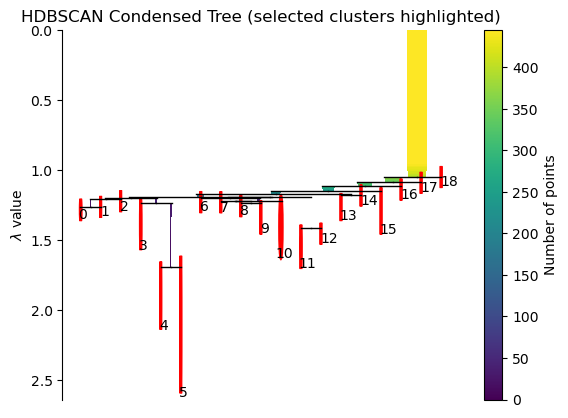

In [1]:
# %% [single-cell PoC] PubMed → Qwen3 embeddings (title+abstract, no cap) → length-bucketed encoding
# → HDBSCAN (no UMAP) → TF-IDF topics → LM Studio LLM labels → TF-IDF k-means comparison
#
# What this does:
# 1) Pull ~1000 most recent PubMed records (last ~3y) for a query (default below).
# 2) Build "passage: {title}\n\n{abstract}" strings (title+abstract is the default).
# 3) Embed with Qwen/Qwen3-Embedding-0.6B on CUDA, FP16, NO token cap.
#    Uses LENGTH BUCKETING (short docs in big batches, long docs in small batches) + OOM backoff.
# 4) Cluster directly in 1024-D with HDBSCAN (metric='euclidean' on L2-normalized vectors → ≈ cosine).
# 5) For each cluster: compute TF-IDF top n-grams, pick central docs; ask LM Studio (gemma-3n-e2b-it)
#    to propose a concise label from those hints.
# 6) Build a TF-IDF+k-means lexical clustering and compare to HDBSCAN with ARI/AMI (diagnostic).
#
# Notes:
# - No UMAP anywhere (you asked to keep 1024-D embeddings).
# - No token cap; we only bucket by length to keep batches stable on a 6–8 GB GPU.
# - EFetch is CHUNKED to avoid 414 (URI too long).
# - If flash-attn is installed, you can toggle it in model_kwargs. We default to safe settings.
# ---------------------------------------------------------------------

import os, sys, time, math, json, re, textwrap
import datetime as dt
from collections import Counter, defaultdict

import requests
import numpy as np
import pandas as pd

import torch
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import adjusted_rand_score as ARI, adjusted_mutual_info_score as AMI, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness

import hdbscan
from hdbscan.validity import validity_index as HDBSCAN_DBCV
import umap

# Optional: plotting
import matplotlib.pyplot as plt
try:
    import plotly.express as px
    _HAS_PLOTLY = True
except Exception:
    _HAS_PLOTLY = False

# HDBSCAN plotting helpers (condensed tree)
import hdbscan.plots as hdb_plots

try:
    from lxml import etree as LETREE
    LXML = True
except Exception:
    import xml.etree.ElementTree as LETREE
    LXML = False

# -------------------------
# Config (edit to taste)
# -------------------------

QUERY = (
    r'("Preanesthetic Evaluation"[Mesh] OR "Preoperative Care"[Mesh] '
    r'OR preanesthetic*[tiab] OR pre-anesthetic*[tiab] '
    r'OR "preoperative assessment"[tiab] OR "preoperative evaluation"[tiab] '
    r'OR "anesthetic assessment"[tiab] OR "anesthetic evaluation"[tiab]) '
    r'AND '
    r'("Pregnancy"[Mesh] OR "Pregnant Women"[Mesh] OR pregnan*[tiab] '
    r'OR gestation[tiab] OR obstetric*[tiab])'
)
#'hypertension randomized controlled trial'
YEARS_BACK          = 10
RETMAX              = 1000
EFETCH_CHUNK_SIZE   = 200                     # <=200 IDs per efetch to avoid 414
LM_BASE_URL         = "http://localhost:1234"
LM_LLM_ID           = "gemma-3n-e2b-it"       # for cluster labeling via LM Studio
MODEL_ID            = "Qwen/Qwen3-Embedding-0.6B"
DEVICE              = "cuda" if torch.cuda.is_available() else "cpu"
TORCH_DTYPE         = torch.float16           # FP16 weights/compute; vectors returned as float32 after normalize

# Length-bucketing: token-length cut points and per-bucket batch sizes
BUCKET_QUANTILES    = [0.50, 0.80, 0.95, 1.00] # token-length quantiles
BUCKET_BATCH_SIZES  = [32,    16,   8,    4]   # batch sizes per bucket (tune for your VRAM)

HDBSCAN_MIN_CLUSTER = 3 #recall that min_cluster >= min_samples
HDBSCAN_MIN_SAMPLES = 3

MAX_LABEL_CLUSTERS  = 12                      # label top-N clusters via LLM
LM_TIMEOUT_S        = 60
SEED                = 42

#for titles sent to LM for cluster labelling
MAX_TITLES = 30
MAX_TITLE_CHARS = 360

np.random.seed(SEED)
torch.manual_seed(SEED)

# Optional: let PyTorch use expandable segments to reduce fragmentation issues
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

# -------------------------
# Helpers: GPU & timing
# -------------------------
def gpu_info():
    if torch.cuda.is_available():
        name = torch.cuda.get_device_name(0)
        free, total = torch.cuda.mem_get_info()
        used = total - free
        return f"CUDA: {name} | VRAM total={total/2**30:.2f} GB, free={free/2**30:.2f} GB, used={used/2**30:.2f} GB"
    return "CUDA: not available"

def tnow(): return time.perf_counter()

def pretty_sec(s):
    if s < 60: return f"{s:.1f}s"
    m = int(s // 60)
    return f"{m}m{(s - 60*m):.1f}s"

# -------------------------
# 1) PubMed fetch (last ~3y) with CHUNKED efetch
# -------------------------
def pubmed_esearch(query, mindate, maxdate, retmax=1000):
    term = f'({query}) AND ("{mindate}"[Date - Publication] : "{maxdate}"[Date - Publication])'
    params = {"db":"pubmed","term":term,"retmax":str(retmax),"sort":"pub+date","retmode":"json"}
    r = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", params=params, timeout=60)
    r.raise_for_status()
    js = r.json()
    return js.get("esearchresult",{}).get("idlist",[])

def _text_if(elem):
    return (elem.text or "").strip() if elem is not None else ""

def _extract_sections(abs_node):
    """Return (normalized_sections_dict, full_abstract_text)."""
    if abs_node is None:
        return {}, ""
    parts, sections = [], {}
    for at in abs_node.findall(".//AbstractText"):
        label = (at.get("Label") or at.get("NlmCategory") or "").lower().strip()
        txt = "".join(at.itertext()).strip()
        if not txt: continue
        parts.append(txt)
        key = (
            "background" if "background" in label else
            "objective"  if "objective"  in label else
            "methods"    if ("methods" in label or "method" in label) else
            "results"    if "results" in label else
            "conclusion" if ("conclusion" in label or "interpretation" in label) else
            label
        )
        sections.setdefault(key, "")
        sections[key] += ((" " + txt) if sections[key] else txt)
    return sections, " ".join(parts).strip()

def pubmed_efetch_batched(pmids, chunk=200, timeout=120):
    records = []
    for i in range(0, len(pmids), chunk):
        sub = pmids[i:i+chunk]
        ids = ",".join(sub)
        r = requests.get(
            "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi",
            params={"db":"pubmed","id":ids,"retmode":"xml"},
            timeout=timeout
        )
        r.raise_for_status()
        xml = r.text
        root = LETREE.fromstring(xml.encode("utf-8")) if LXML else LETREE.fromstring(xml)
        for art in root.findall(".//PubmedArticle"):
            pmid = _text_if(art.find(".//PMID"))
            title = _text_if(art.find(".//ArticleTitle"))
            abs_node = art.find(".//Abstract")
            sections, abstr = _extract_sections(abs_node)
            journal = _text_if(art.find(".//Journal/Title"))
            year = _text_if(art.find(".//Journal/JournalIssue/PubDate/Year"))
            doc = title.strip()
            if abstr: doc = f"{doc}\n\n{abstr.strip()}".strip()
            records.append({
                "pmid": pmid, "title": title, "abstract": abstr,
                "doc": doc, "sections": sections, "journal": journal, "year": year
            })
        print(f"[efetch] {i}-{i+len(sub)-1} → parsed {len(sub)} items (acc={len(records)})")
    return records

def summarize_sections(records):
    keys = ["background","methods","results","conclusion","objective"]
    cnt = Counter()
    for r in records:
        s = r["sections"]
        for k in keys:
            if k in s and s[k].strip(): cnt[k] += 1
    n = max(1,len(records))
    return {k:100.0*cnt[k]/n for k in keys}

# -------------------------
# 2) Embedding (Qwen) with length bucketing (no cap)
# -------------------------
def estimate_token_lengths(tokenizer, texts):
    lens = []
    for t in texts:
        enc = tokenizer(
            t, add_special_tokens=True, truncation=False,
            return_attention_mask=False, return_token_type_ids=False
        )
        lens.append(len(enc["input_ids"]))
    return np.array(lens, dtype=np.int32)

def make_passage_text(r):
    # Qwen3 doc prefix; keep document natural
    title = (r["title"] or "").strip().replace("\n"," ")
    abstr = (r["abstract"] or "").strip().replace("\n"," ")
    txt = title if not abstr else f"{title}\n\n{abstr}"
    return "passage: " + txt.strip()

def l2_normalize(mat, eps=1e-12):
    n = np.linalg.norm(mat, axis=1, keepdims=True)
    n = np.maximum(n, eps)
    return mat / n

def _bucket_edges(lengths, quantiles):
    edges = np.quantile(lengths, quantiles)
    return np.maximum.accumulate(edges)  # monotone non-decreasing

def _bucket_index(L, edges):
    # returns bucket idx in [0..len(edges)-1]
    return int(np.searchsorted(edges, L, side="left"))

def embed_bucketed(model, tokenizer, docs, lengths, qtiles, bucket_bsz, device=DEVICE):
    """
    docs: list[str] (already prefixed "passage: ...")
    lengths: np.array of token counts
    qtiles: e.g., [0.5, 0.8, 0.95, 1.0]
    bucket_bsz: e.g., [32, 16, 8, 4]
    """
    assert len(qtiles) == len(bucket_bsz)
    edges = _bucket_edges(lengths, qtiles)

    # Indices sorted by length
    order = np.argsort(lengths)
    # Pre-assign bucket for each item
    bucket_of = np.array([_bucket_index(lengths[i], edges) for i in range(len(lengths))], dtype=np.int32)

    out = np.zeros((len(docs), 1024), dtype=np.float32)  # Qwen3-0.6B dim=1024

    print(f"\n=== Embedding (bucketed, NO token cap) ===")
    print(gpu_info())

    # Warmup shortest one to compile kernels
    try:
        w_idx = int(order[0])
        _ = model.encode([docs[w_idx]], batch_size=1, convert_to_numpy=True, device=device, normalize_embeddings=True)
    except Exception as e:
        print(f"[warmup warn] {e}")
    print(f"[warmup] 1 item | {gpu_info()}")

    i = 0
    run_times = []
    while i < len(order):
        first = order[i]
        bidx  = bucket_of[first]
        bsz   = int(bucket_bsz[bidx])
        # Build a "run" inside this bucket (to keep padding tight)
        run_ids = []
        j = i
        run_cap = 4 * bsz  # up to ~4 batches per run
        while j < len(order) and len(run_ids) < run_cap and bucket_of[order[j]] == bidx:
            run_ids.append(order[j])
            j += 1

        texts = [docs[k] for k in run_ids]
        t0 = tnow()
        cur_bsz = bsz
        while True:
            try:
                embs = model.encode(
                    texts,
                    batch_size=cur_bsz,
                    convert_to_numpy=True,
                    device=device,
                    normalize_embeddings=True
                )
                break
            except torch.cuda.OutOfMemoryError:
                torch.cuda.empty_cache()
                cur_bsz = max(1, cur_bsz // 2)
                print(f"[OOM] bucket={bidx} lowering batch_size to {cur_bsz} | {gpu_info()}")
                if cur_bsz == 1:
                    # encode item-by-item if needed
                    out_list = []
                    for t_one in texts:
                        ok = False
                        while not ok:
                            try:
                                e1 = model.encode([t_one], batch_size=1, convert_to_numpy=True,
                                                  device=device, normalize_embeddings=True)
                                out_list.append(e1[0]); ok = True
                            except torch.cuda.OutOfMemoryError:
                                torch.cuda.empty_cache(); time.sleep(0.2)
                    embs = np.vstack(out_list)
                    break

        dt = tnow() - t0
        run_times.append(dt)
        for pos, k in enumerate(run_ids):
            out[k] = embs[pos]
        rate = len(run_ids)/max(dt,1e-9)
        span = f"{min(run_ids)}-{max(run_ids)}" if len(run_ids)>1 else f"{run_ids[0]}"
        print(f"[run ok] idx {span} | size={len(run_ids)} | bucket={bidx} bsz={cur_bsz} | {dt:.2f}s | {rate:.2f} items/s | {gpu_info()}")

        i = j

    stats = {
        "count": len(docs),
        "total_time_s": float(sum(run_times)),
        "items_per_sec": len(docs)/max(float(sum(run_times)),1e-9),
        "median_run_time_s": float(np.median(run_times)) if run_times else None,
        "p95_run_time_s": float(np.percentile(run_times,95)) if run_times else None,
    }
    print("---- Embedding stats ----", stats)
    return out, stats

# -------------------------
# 3) HDBSCAN (directly in 1024-D)
# -------------------------
def hdbscan_cluster(embeddings, min_cluster_size=HDBSCAN_MIN_CLUSTER, min_samples=HDBSCAN_MIN_SAMPLES):
    cl = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean', # L2-normalized → monotone to cosine
        cluster_selection_method='leaf',
        cluster_selection_epsilon=0.0,  # <- was 0.03; set to 0 to avoid merges
        core_dist_n_jobs=1,
        prediction_data=True  # helpful for out-of-sample & probs
    )
    t0 = tnow()
    labels = cl.fit_predict(embeddings)
    dt = tnow()-t0
    lab_counts = Counter(labels)
    n = len(labels)
    noise = lab_counts.get(-1,0)
    clusters = {k:v for k,v in lab_counts.items() if k!=-1}
    print("\n=== HDBSCAN summary (1024-D, no UMAP) ===")
    print(f"time: {pretty_sec(dt)} | points={n} | clusters={len(clusters)} | noise={noise/n*100:.1f}%")
    if clusters:
        top = dict(sorted(clusters.items(), key=lambda kv: kv[1], reverse=True)[:10])
        top = {int(k): int(v) for k, v in top.items()}
        print("top cluster sizes:", top)
    return labels, getattr(cl, "probabilities_", None), cl

def l2_normalize_matrix(M):
    return l2_normalize(M)

def cluster_centroids(embs, labels):
    groups = defaultdict(list)
    for i,c in enumerate(labels):
        if c==-1: continue
        groups[c].append(i)
    cents = {}
    for c, idxs in groups.items():
        V = embs[idxs]
        v = V.mean(axis=0, keepdims=True)
        v = l2_normalize(v)[0]
        cents[c] = (v, np.array(idxs, dtype=np.int32))
    return cents

def remap_labels_contiguous(labels):
    """Map cluster labels to 0..K-1 while keeping noise=-1, useful for some metrics."""
    unique = sorted(set(labels) - {-1})
    mapping = {c:i for i,c in enumerate(unique)}
    out = np.full_like(labels, fill_value=-1)
    for i, c in enumerate(labels):
        if c == -1: continue
        out[i] = mapping[c]
    return out

def cluster_metrics_table(embs, labels, probs, clusterer, cents):
    """
    Build a per-cluster DataFrame with:
      - size
      - selection persistence (stability) from HDBSCAN
      - exemplar count
      - prob mean/median/p05
      - cosine-to-centroid mean/median/p05
    """
    # Map persistence to label ids
    # clusterer.cluster_persistence_ is aligned with unique cluster labels in ascending order:
    #     clusterer.labels_ contains the per-point labels
    unique_labels = sorted(set(labels) - {-1})
    persistence = {}
    if hasattr(clusterer, "cluster_persistence_"):
        for lab, pers in zip(unique_labels, clusterer.cluster_persistence_):
            persistence[int(lab)] = float(pers)

    # exemplars_: list of arrays of exemplar points per cluster, in label order
    exemplar_count = {}
    if hasattr(clusterer, "exemplars_") and clusterer.exemplars_ is not None:
        for lab, ex in zip(unique_labels, clusterer.exemplars_):
            exemplar_count[int(lab)] = int(len(ex))
    else:
        for lab in unique_labels:
            exemplar_count[int(lab)] = 0

    rows = []
    for c, (cent, idxs) in sorted(cents.items(), key=lambda kv: len(kv[1][1]), reverse=True):
        idxs = idxs.astype(int)
        V = embs[idxs]
        cos = (V @ cent).ravel()  # cosine to centroid (embs are L2-normalized)
        p  = (probs[idxs] if probs is not None else np.ones(len(idxs)))

        def pctl(x, q): return float(np.percentile(x, q)) if len(x) else float('nan')
        
        if len(idxs) >= 3:
            mp = float((V @ V.T).mean())  # mean pairwise cosine
        else:
            mp = float('nan')

        rows.append({
            "cluster":            int(c),
            "size":               int(len(idxs)),
            "persistence":        float(persistence.get(int(c), float('nan'))),
            "exemplar_count":     int(exemplar_count.get(int(c), 0)),
            "prob_mean":          float(np.mean(p)),
            "prob_median":        float(np.median(p)),
            "prob_p05":           pctl(p, 5),
            "cos_mean":           float(np.mean(cos)),
            "cos_median":         float(np.median(cos)),
            "cos_p05":            pctl(cos, 5),
            "cos_pair_mean":      mp,
        })
    return pd.DataFrame(rows)

# -------------------------
# 4) TF-IDF per cluster + k-means baseline
# -------------------------
def tfidf_top_terms_per_cluster(texts, labels, top_k=12, ngram=(1,2)):
    # minimal, general-purpose settings
    vect = TfidfVectorizer(
        stop_words='english',     # kill the, and, of, in…
        ngram_range=ngram,
        min_df=2,                 # remove singletons
        max_df=0.9,               # drop super-ubiquitous tokens
        sublinear_tf=True,        # 1 + log(tf)
        norm=None,                # don't row-normalize; we'll work with means
        max_features=50000
    )
    X = vect.fit_transform(texts)
    vocab = np.array(vect.get_feature_names_out())

    # global baseline (so we rank terms that are *overrepresented* in the cluster)
    X_global_mean = np.asarray(X.mean(axis=0)).ravel()

    out = {}
    for c in sorted(set(labels)):
        if c == -1:
            continue
        mask = (labels == c)
        if mask.sum() < 3:
            out[c] = []
            continue

        m = np.asarray(X[mask].mean(axis=0)).ravel()
        score = m - X_global_mean           # contrastive "lift"
        if score.size == 0:
            out[c] = []
            continue

        k = min(top_k, score.size)
        top_idx = np.argpartition(-score, k-1)[:k]
        top_idx = top_idx[np.argsort(-score[top_idx])]
        out[c] = [(vocab[i], float(score[i])) for i in top_idx]
    return out

def tfidf_kmeans_labels(texts, k_candidates=(8,12,16,20,24,28,32), ngram=(1,2)):
    vect = TfidfVectorizer(
        stop_words='english',
        ngram_range=ngram,
        min_df=2,
        max_df=0.9,
        sublinear_tf=True,
        max_features=50000
        # leave norm='l2' default for cosine geometry
    )
    X = vect.fit_transform(texts)
    Xn = normalize(X)  # safety; keeps silhouette(metric='cosine') happy

    best = None
    for k in k_candidates:
        km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
        labs = km.fit_predict(Xn)
        try:
            sil = silhouette_score(Xn, labs, metric='cosine')
        except Exception:
            sil = np.nan
        cand = (sil, k, labs)
        if best is None or (np.nan_to_num(sil, nan=-1e9) > np.nan_to_num(best[0], nan=-1e9)):
            best = cand
    sil, k, labs = best
    return labs, {"k": int(k), "silhouette_cosine": float(sil)}

# -------------------------
# 5) LM Studio (LLM) labeling
# -------------------------
def lm_list_models():
    try:
        r = requests.get(f"{LM_BASE_URL}/v1/models", timeout=LM_TIMEOUT_S)
        r.raise_for_status()
        return [x["id"] for x in r.json().get("data",[])]
    except Exception as e:
        print(f"[LM list warn] {e}")
        return []

def lm_label_cluster(llm_model, size, top_terms, central_titles, timeout=LM_TIMEOUT_S):
    # Prefer bigrams for cleaner topical cues
    bigram_terms = [t for t,_ in top_terms if " " in t]
    terms_str = ", ".join(bigram_terms[:12])

    # Build a compact bullet list of titles
    title_lines = "\n".join([f"- {t}" for t in central_titles])

    sys_prompt = (
        "You are an expert biomedical literature curator.\n"
        "Given titles that are central to a cluster and its top n-grams, produce:\n"
        "1) label: ≤ 8 words, specific (avoid generic terms like 'study' or 'patients').\n"
        "2) desc: one sentence that names population, intervention/exposure, and the main outcome or comparator.\n"
        "Return a single JSON object with exactly keys: {\"label\":..., \"desc\":...}. No markdown fences."
    )

    user_prompt = (
        f"Cluster size: {size}\n"
        f"Top n-grams (bigrams): {terms_str}\n"
        f"Representative titles (most central first):\n{title_lines}\n"
        "JSON only."
    )

    body = {
        "model": llm_model,
        "messages": [
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "temperature": 0.1,       # crisper wording
        "max_tokens": 520,        # allow a longer desc if needed
        "stream": False
    }

    try:
        r = requests.post(
            f"{LM_BASE_URL}/v1/chat/completions",
            headers={"Content-Type": "application/json"},
            data=json.dumps(body),
            timeout=timeout
        )
        r.raise_for_status()
        msg = r.json()["choices"][0]["message"]["content"].strip()
        # be tolerant to accidental code fences
        if msg.startswith("```"):
            msg = re.sub(r"^```(?:json)?|```$", "", msg, flags=re.MULTILINE).strip()
        js = json.loads(msg)
        return js.get("label","(no label)"), js.get("desc","")
    except Exception as e:
        return f"(LLM error: {e})", ""
    
# -------------------------
# Plotting
# -------------------------    

def report_clusters_and_plot(embs, labels, probs, titles, pmids, SEED=42):
    """Print detailed cluster metrics and draw both PCA and (if available) UMAP 2D scatters."""
    import numpy as np
    from collections import Counter, defaultdict

    # ---- Global stats
    n = len(labels)
    counts = Counter(labels)
    n_noise = counts.get(-1, 0)
    n_clusters = len([c for c in counts if c != -1])
    print("\n=== Cluster metrics ===")
    print(f"points={n} | clusters={n_clusters} | noise={100.0*n_noise/n:.1f}%")

    # ---- Per-cluster stats (size, prob quality, compactness)
    # Build centroids for intra-cluster similarity summaries
    groups = defaultdict(list)
    for i, c in enumerate(labels):
        if c != -1:
            groups[c].append(i)

    def _l2norm(X, eps=1e-12):
        nrm = np.maximum(np.linalg.norm(X, axis=1, keepdims=True), eps)
        return X / nrm

    rows = []
    for c, idxs in sorted(groups.items(), key=lambda kv: len(kv[1]), reverse=True):
        V = embs[idxs]                 # unit if you kept normalize_embeddings=True
        cent = _l2norm(V.mean(axis=0, keepdims=True))[0]
        sims = V @ cent                # cosine to centroid
        p = probs[idxs] if probs is not None else np.ones(len(idxs))
        rows.append({
            "cluster": int(c),
            "size": len(idxs),
            "prob_mean": float(np.mean(p)),
            "prob_med":  float(np.median(p)),
            "sim_mean":  float(np.mean(sims)),
            "sim_med":   float(np.median(sims)),
            "sim_p10":   float(np.percentile(sims, 10)),
            "sim_p90":   float(np.percentile(sims, 90)),
        })

    if rows:
        df_metrics = pd.DataFrame(rows).sort_values(["size","sim_mean"], ascending=[False,False])
        print(df_metrics.to_string(index=False))
    else:
        print("(no clusters)")

    # ---- Silhouette on core (exclude noise); cosine is correct for L2-normalized embeddings
    core_mask = labels != -1
    if core_mask.sum() >= 10 and len(set(labels[core_mask])) > 1:
        try:
            sil = silhouette_score(embs[core_mask], labels[core_mask], metric='cosine')
            print(f"silhouette(core, cosine): {sil:.3f}")
        except Exception as e:
            print(f"[silhouette warn] {e}")
    else:
        print("silhouette: not enough clustered points or only one cluster.")

    # ---- DBCV (density-based validity) via HDBSCAN helper (euclidean on unit vectors ~= cosine)
    try:
        from hdbscan import validity
        dbcv = validity.validity_index(embs, labels, metric='euclidean')
        print(f"DBCV (all points): {dbcv:.3f}")
    except Exception as e:
        print(f"[DBCV warn] {e}")

    # ---- 2D visualizations: PCA and UMAP (if available), with trustworthiness
    def _scatter(proj, title):
        cluster_str = np.array([str(c) for c in labels])
        prob_plot   = probs if probs is not None else np.ones(len(labels), dtype=float)
        if _HAS_PLOTLY:
            dfp = pd.DataFrame({"x":proj[:,0], "y":proj[:,1], "cluster":cluster_str, "prob":prob_plot})
            fig = px.scatter(dfp, x="x", y="y", color="cluster", hover_data=["cluster","prob"],
                             opacity=0.9, title=title)
            fig.show()
        else:
            uniq = sorted(set(labels))
            cmap = plt.cm.get_cmap('tab20', max(2, len(uniq)))
            plt.figure(figsize=(7.2,6))
            for i,c in enumerate(uniq):
                mask = (labels == c)
                if c == -1:
                    plt.scatter(proj[mask,0], proj[mask,1], s=8, alpha=0.25, color='lightgray', label="noise")
                else:
                    plt.scatter(proj[mask,0], proj[mask,1], s=12, alpha=0.85, color=cmap(i), label=f"c{c}")
            plt.legend(markerscale=1.5, fontsize=8, ncol=2)
            plt.title(title); plt.xlabel("dim 1"); plt.ylabel("dim 2"); plt.tight_layout(); plt.show()

    # PCA
    pca = PCA(n_components=2, random_state=SEED)
    proj_pca = pca.fit_transform(embs)
    tw_pca = trustworthiness(embs, proj_pca, n_neighbors=25, metric='euclidean')
    print(f"PCA trustworthiness@25: {tw_pca:.3f}")
    _scatter(proj_pca, f"PCA(2D) — trustworthiness@25={tw_pca:.3f}")

    # UMAP
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=25,   # local-vs-global balance
        min_dist=0.1,     # visual compactness in 2D
        metric='cosine',  # matches embedding geometry
        random_state=SEED,
        verbose=False
    )
    proj_umap = reducer.fit_transform(embs)
    tw_umap = trustworthiness(embs, proj_umap, n_neighbors=25, metric='euclidean')
    print(f"UMAP trustworthiness@25: {tw_umap:.3f}")
    _scatter(proj_umap, f"UMAP(2D, cosine) — trustworthiness@25={tw_umap:.3f}")
# -------------------------
# Run
# -------------------------
print("=== Environment ===")
print(f"torch={torch.__version__} | transformers={__import__('transformers').__version__} | sentence-transformers={__import__('sentence_transformers').__version__}")
print(gpu_info())

# 1) Fetch PubMed (last ~3y)
today  = dt.date.today()
start  = today.replace(year=today.year - YEARS_BACK)
mindate = start.strftime("%Y/%m/%d")
maxdate = today.strftime("%Y/%m/%d")

print("\n=== PubMed fetch ===")
t0 = tnow()
pmids = pubmed_esearch(QUERY, mindate, maxdate, RETMAX)
print(f"esearch: {len(pmids)} PMIDs")
records = pubmed_efetch_batched(pmids, chunk=EFETCH_CHUNK_SIZE, timeout=120)
print(f"efetch+parse: {len(records)} records | {pretty_sec(tnow()-t0)}")

# Build passage texts (title + abstract)
docs   = [make_passage_text(r) for r in records]
titles = [r["title"] for r in records]
pmids  = [r["pmid"]  for r in records]

# Section coverage
coverage = summarize_sections(records)
print("\n=== Section coverage (detected) ===")
for k in ["background","methods","results","conclusion","objective"]:
    print(f"{k:>10}: {coverage.get(k,0):5.1f}%")

# 2) Load embedding model (FP16, no explicit flash_attn)
print("\n[model] Loading", MODEL_ID, "...")
try:
    model = SentenceTransformer(
        MODEL_ID,
        device=DEVICE,
        model_kwargs={"torch_dtype": TORCH_DTYPE},
    )
except Exception as e:
    print(f"[load warn] {e} | retry without dtype")
    model = SentenceTransformer(MODEL_ID, device=DEVICE)
print(f"[model] Loaded '{model.__class__.__name__}' on {DEVICE} | {gpu_info()}")
tokenizer = model.tokenizer

# Estimate token lengths (no truncation)
lens = estimate_token_lengths(tokenizer, docs)
print(f"\nPrepared texts: N={len(docs)} | title+abstract (no cap)")
print(f"[TOKENS] min={int(lens.min())}, p50={int(np.median(lens))}, p95={int(np.percentile(lens,95))}, max={int(lens.max())}")

# 3) Embed with length bucketing
embs, embed_stats = embed_bucketed(model, tokenizer, docs, lens, BUCKET_QUANTILES, BUCKET_BATCH_SIZES, device=DEVICE)
# embs already L2-normalized by SentenceTransformers when normalize_embeddings=True

# (double-normalize safety; harmless)
embs = l2_normalize_matrix(embs)

# 4) HDBSCAN in 1024-D
labels, probs, clusterer = hdbscan_cluster(embs, min_cluster_size=HDBSCAN_MIN_CLUSTER, min_samples=HDBSCAN_MIN_SAMPLES)

# --- Global validity metrics ---
mask_core = labels != -1
labels_core = labels[mask_core]
embs_core   = embs[mask_core]

# DBCV (density-based cluster validation); higher is better; undefined if <2 clusters
def safe_dbcv(X, labels, metric='euclidean'):
    X64 = np.asarray(X, dtype=np.float64)
    return HDBSCAN_DBCV(X64, labels, metric=metric)

try:
    dbcv_all  = safe_dbcv(embs, labels)  # instead of directly passing embs
except Exception:
    dbcv_all = float('nan')

dbcv_core = safe_dbcv(embs_core, labels_core) if len(set(labels_core))>1 else float('nan')

# Silhouette (cosine) on core points (needs >=2 clusters)
try:
    sil_core = silhouette_score(embs_core, labels_core, metric='cosine') if len(set(labels_core)) > 1 else float('nan')
except Exception:
    sil_core = float('nan')

print(f"DBCV (all):  {dbcv_all:.3f}")
print(f"DBCV (core): {dbcv_core:.3f}")
print(f"Silhouette (cosine, core): {sil_core:.3f}")

# Outlier scores overview (0..1; larger ~ more outlier-like)
if hasattr(clusterer, "outlier_scores_") and clusterer.outlier_scores_ is not None:
    os_ = clusterer.outlier_scores_
    pcts = np.percentile(os_, [5, 25, 50, 75, 95])
    print(f"Outlier scores p05/25/50/75/95: {pcts.round(3)}")

# 5) Per-cluster TF-IDF top terms + representative docs (central to centroid)
cents = cluster_centroids(embs, labels)
tfidf_tops = tfidf_top_terms_per_cluster([r["doc"] for r in records], labels, top_k=12, ngram=(1,2))

metrics_df = cluster_metrics_table(embs, labels, probs, clusterer, cents)
if not metrics_df.empty:
    print("\n=== Per-cluster metrics (sorted by size) ===")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(metrics_df.sort_values('size', ascending=False).to_string(index=False))

# Representative docs per cluster
cluster_summaries = []
for c, (cent, idxs) in sorted(cents.items(), key=lambda kv: len(kv[1][1]), reverse=True):
    V = embs[idxs]
    sims = V @ cent  # cosine (both L2-normed)
    order = np.argsort(-sims)
    core_ids = idxs[order]
    central = [(int(core_ids[i]), float(sims[order[i]])) for i in range(min(MAX_TITLES, len(core_ids)))]
    cluster_summaries.append((c, idxs, central))

# 6) Ask LM Studio to label top clusters (by size)
lm_models = lm_list_models()
if LM_LLM_ID not in lm_models:
    print(f"\n[LM] Warning: '{LM_LLM_ID}' not listed by LM Studio. Available: {lm_models}")

print("\n=== Cluster labels via LM Studio ===")
labeled = {}
for c, idxs, central in cluster_summaries[:MAX_LABEL_CLUSTERS]:
    size = len(idxs)
    terms = tfidf_tops.get(c, [])
    central_titles = [ (titles[i] or "")[:MAX_TITLE_CHARS] for (i, _) in central[:MAX_TITLES] ]
    label, desc = lm_label_cluster(LM_LLM_ID, size, terms, central_titles, timeout=LM_TIMEOUT_S)
    labeled[c] = {"label":label, "desc":desc, "size":size}
    print(f"[c={c:>3} | n={size:>3}] label={label}\n  desc: {desc}")

# 7) TF-IDF k-means baseline and ARI/AMI comparison (diagnostic)
print("\n=== TF-IDF k-means (lexical) vs HDBSCAN (semantic) ===")
lex_labels, km_info = tfidf_kmeans_labels([r["doc"] for r in records], k_candidates=(8,12,16,20,24,28,32), ngram=(1,2))
print(f"k-means best k={km_info['k']} | silhouette(cosine)={km_info['silhouette_cosine']:.3f}")

mask_core = labels != -1
if mask_core.sum() >= 2 and len(set(labels[mask_core]))>1 and len(set(lex_labels[mask_core]))>1:
    ari_val = float(ARI(labels[mask_core], lex_labels[mask_core]))
    ami_val = float(AMI(labels[mask_core], lex_labels[mask_core]))
    print(f"ARI(core): {ari_val:.3f}")
    print(f"AMI(core): {ami_val:.3f}")
else:
    print("Not enough clustered (non-noise) points for ARI/AMI.")

# 8) Human-readable cluster report (largest few)
print("\n=== Cluster report (largest first) ===")
for c, idxs, central in cluster_summaries[:MAX_LABEL_CLUSTERS]:
    lbl = labeled.get(c, {})
    tag = lbl.get("label","")
    desc = lbl.get("desc","")
    terms = ", ".join([t for t,_ in (tfidf_tops.get(c,[]) or [])[:10]])
    print(f"\n[c={c}] n={len(idxs)} | {tag}")
    if desc:  print(f"  {desc}")
    if terms: print(f"  top terms: {terms}")
    print("  central titles:")
    for i,(idx,sim) in enumerate(central, start=1):
        print(f"   {i:>2}. (cos={sim:.3f}) PMID={pmids[idx]} :: {titles[idx][:160]}")

print("\n=== Summary ===")
print(f"Query: '{QUERY}' | window: {mindate}..{maxdate}")
print(f"Fetched: {len(records)} | Embedded: {len(embs)}")
print(f"HDBSCAN clusters: {len(set(labels)) - (1 if -1 in labels else 0)} | Noise%: {100.0*(labels==-1).mean():.1f}%")
print(f"Embedding throughput: {embed_stats['items_per_sec']:.2f} items/s | total≈{pretty_sec(embed_stats['total_time_s'])}")
print(gpu_info())

report_clusters_and_plot(embs, labels, probs, titles, pmids, SEED=SEED)

# === Condensed tree (HDBSCAN) ===
try:
    ct = getattr(clusterer, "condensed_tree_", None)
    if ct is None:
        print("[plot warn] clusterer has no condensed_tree_ attribute.")
    else:
        # Preferred path: newer hdbscan where condensed_tree_ is a CondensedTree object
        if hasattr(ct, "plot"):
            ax = ct.plot(select_clusters=True, label_clusters=True, colorbar=True)
            plt.title("HDBSCAN Condensed Tree (selected clusters highlighted)")
            plt.show()
        else:
            # Fallback: very old installs where condensed_tree_ is a structured array
            import hdbscan.plots as hdb_plots
            arr = ct.to_numpy() if hasattr(ct, "to_numpy") else ct  # be defensive
            ct_wrap = hdb_plots.CondensedTree(
                arr,
                cluster_selection_method=getattr(clusterer, "cluster_selection_method", "eom"),
            )
            ax = ct_wrap.plot(select_clusters=True, label_clusters=True, colorbar=True)
            plt.title("HDBSCAN Condensed Tree (compat mode)")
            plt.show()
except Exception as e:
    print(f"[plot warn] condensed tree plot failed even after compatibility shim: {e}")

[iCite] items=31 | empty refs=1 | empty cited_by=3
[iCite] items=51 | empty refs=2 | empty cited_by=1
[iCite] items=12 | empty refs=2 | empty cited_by=1
[iCite] items=19 | empty refs=0 | empty cited_by=0
[iCite] items=12 | empty refs=1 | empty cited_by=2
[iCite] items=26 | empty refs=0 | empty cited_by=0
[iCite] items=11 | empty refs=0 | empty cited_by=3
[iCite] items=20 | empty refs=0 | empty cited_by=0
[iCite] items=8 | empty refs=1 | empty cited_by=2
[iCite] items=7 | empty refs=0 | empty cited_by=0
[iCite] items=8 | empty refs=1 | empty cited_by=2
[iCite] items=32 | empty refs=0 | empty cited_by=2
[iCite] items=6 | empty refs=0 | empty cited_by=0
[iCite] items=8 | empty refs=1 | empty cited_by=1
[iCite] items=6 | empty refs=1 | empty cited_by=1
[iCite] items=12 | empty refs=0 | empty cited_by=1
[iCite] items=6 | empty refs=0 | empty cited_by=0
[iCite] items=15 | empty refs=0 | empty cited_by=0
[iCite] items=6 | empty refs=1 | empty cited_by=2
[iCite] items=15 | empty refs=0 | empty

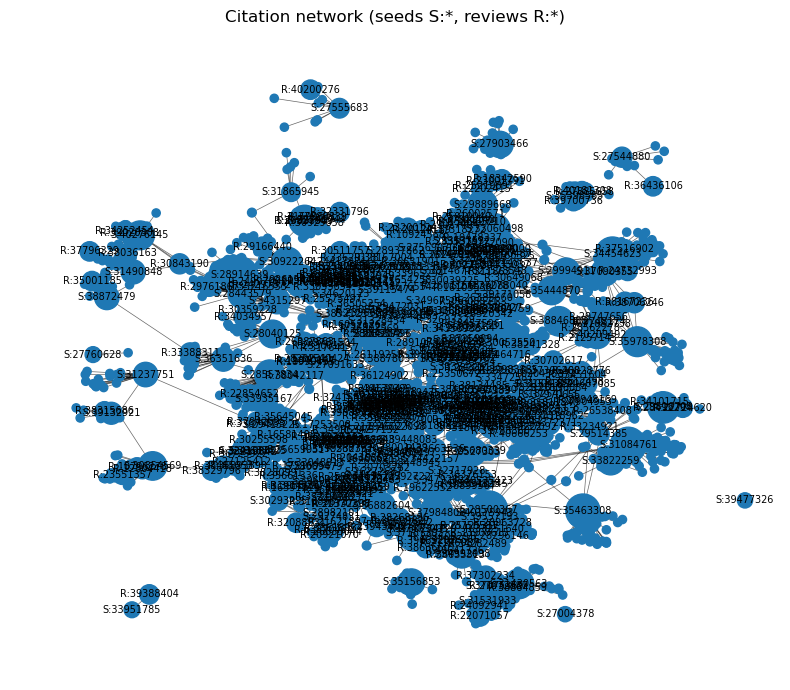

Artifacts:
 - /mnt/data/cluster_sr_candidates.csv
 - /mnt/data/citation_edges.json


In [4]:
# %% [follow-up: PubMed-only citation ripples → SR coverage per semantic cluster]
import os, time, json, math, re, textwrap
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import requests
import xml.etree.ElementTree as ET

import networkx as nx
import matplotlib.pyplot as plt

# -------------------------
# CONFIG
# -------------------------
USE_ICITE               = True                      # NIH iCite OCC for citations (PMID-only)
ICITE_BATCH             = 1000                      # /api/pubs?pmids=… accepts up to 1000
PUBMED_API_KEY          = os.getenv("NCBI_API_KEY") # optional; set to raise rate limits
PUBMED_TOOL             = "cluster-sr-coverage"
PUBMED_EMAIL            = os.getenv("NCBI_TOOL_EMAIL", "you@example.org")

ONLY_MEDLINE            = False   # If True, drop non-MEDLINE records when scoring reviews
RIPPLE_DEPTH            = 1       # 1 = just references & cited-by of the seed set
MAX_UPSTREAM_PER_SEED   = 200     # safety caps to prevent runaway graphs
MAX_DOWNSTREAM_PER_SEED = 200

TOP_K_REVIEWS_PER_CLS   = 5       # how many best candidates to report per cluster
W_COVERAGE              = 0.6     # weight of coverage in final score
W_SEMANTIC              = 0.4     # weight of semantic similarity
LM_POLICE_ENABLE        = False   # optional LM Studio policing
LM_BASE_URL             = "http://localhost:1234"
LM_MODEL_ID             = "gemma-3n-e2b-it"
LM_TIMEOUT_S            = 45

# Plotting
FIGSIZE                 = (8.0, 7.0)    # single figure; no explicit colors

# -------------------------
# HELPERS
# -------------------------
def chunked(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def icite_fetch(pmids):
    """
    Robust NIH iCite fetch.
    Returns: { pmid:int -> {"references":[int...], "cited_by":[int...]} }
    - Coerces null arrays to []
    - Accepts canonical or alias field names
    """
    base = "https://icite.od.nih.gov/api/pubs"
    out = {}
    seen = set()
    pmids = [int(p) for p in pmids if str(p).isdigit()]
    if not pmids:
        return out

    def _to_int_list(x):
        if not x: 
            return []
        if isinstance(x, list):
            return [int(y) for y in x if str(y).isdigit()]
        return []

    # iCite handles up to ~1000 per query
    for batch in (pmids[i:i+1000] for i in range(0, len(pmids), 1000)):
        q = ",".join(str(p) for p in batch)
        url = f"{base}?pmids={q}&legacy=false"
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        data = r.json()

        # payload shape is either {"data":[...]} or a bare list
        records = data.get("data", data if isinstance(data, list) else [])
        for rec in records:
            pid = rec.get("pmid")
            if pid is None or not str(pid).isdigit():
                continue
            pid = int(pid)
            if pid in seen:
                continue
            seen.add(pid)

            # Accept both canonical & alias names; coerce None -> []
            refs_raw = rec.get("citedPmids") or rec.get("references") or []
            cby_raw  = rec.get("citedByPmids") or rec.get("cited_by") or []

            refs = _to_int_list(refs_raw)
            cby  = _to_int_list(cby_raw)

            out[pid] = {"references": refs, "cited_by": cby}

    # quick telemetry
    _n_total = len(out)
    _n_empty_refs = sum(1 for v in out.values() if not v["references"])
    _n_empty_cby  = sum(1 for v in out.values() if not v["cited_by"])
    print(f"[iCite] items={_n_total} | empty refs={_n_empty_refs} | empty cited_by={_n_empty_cby}")
    return out

def pubmed_efetch_details(pmids):
    """
    EFetch retmode=xml → parse:
      - MedlineCitation/@Status
      - ArticleTitle
      - AbstractText (concatenated)
      - PublicationTypeList (for SR/MA/Review)
      - Year
    Returns dict pmid -> metadata
    """
    out = {}
    base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "pubmed",
        "retmode": "xml",
    }
    if PUBMED_API_KEY: params["api_key"] = PUBMED_API_KEY
    headers = {"User-Agent": f"{PUBMED_TOOL} ({PUBMED_EMAIL})"}
    for batch in chunked(list(pmids), 200):
        params["id"] = ",".join(str(int(x)) for x in batch)
        r = requests.get(base, params=params, headers=headers, timeout=60)
        r.raise_for_status()
        root = ET.fromstring(r.text.encode("utf-8"))

        for art in root.findall(".//PubmedArticle"):
            pmid = art.findtext(".//PMID")
            if not pmid or not pmid.isdigit(): 
                continue
            pmid = int(pmid)

            medline = art.find(".//MedlineCitation")
            status  = medline.attrib.get("Status","") if medline is not None else ""

            title   = (art.findtext(".//ArticleTitle") or "").strip()
            absnode = art.find(".//Abstract")
            abstr   = ""
            if absnode is not None:
                parts = []
                for at in absnode.findall(".//AbstractText"):
                    parts.append("".join(at.itertext()).strip())
                abstr = " ".join([p for p in parts if p]).strip()

            # Pub types
            ptypes = []
            for pt in art.findall(".//PublicationType"):
                val = (pt.text or "").strip().lower()
                if val: ptypes.append(val)

            year = art.findtext(".//Journal/JournalIssue/PubDate/Year")
            out[pmid] = {
                "status": status,
                "title": title,
                "abstract": abstr,
                "pub_types": ptypes,
                "year": year
            }
    return out

def is_systematic_like(ptypes):
    """Decide if a PubMed record is a systematic review candidate by PublicationTypeList."""
    p = set(x.lower() for x in (ptypes or []))
    return (
        "systematic review" in p or
        "meta-analysis" in p or
        "systematic literature review" in p or
        ("review" in p and ("meta analysis" in " ".join(p) or "systematic" in " ".join(p)))
    )

# --- Semantic scoring (uses your embedding model if present)
def ensure_embedder():
    try:
        return model  # reuse your Qwen model if defined in the notebook
    except NameError:
        pass
    from sentence_transformers import SentenceTransformer
    # Keep it light if your Qwen isn't in scope:
    m = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    return m

def embed_texts(m, texts):
    E = m.encode(texts, convert_to_numpy=True, normalize_embeddings=True, batch_size=64)
    return E.astype(np.float32)

def cosine(a, b):
    return float(np.clip(np.dot(a, b), -1.0, 1.0))

# Optional LLM policeman
def lm_police_relevance(cluster_terms, cluster_titles, sr_title, sr_covered_titles):
    if not LM_POLICE_ENABLE:
        return True, 0.0
    prompt = f"""
You are screening whether a paper is a *systematic review on the same topic* as a given cluster.

Cluster top terms (n-grams): {", ".join(cluster_terms[:12])}
Cluster seed titles (sample):
- {chr(10).join("- " + t for t in cluster_titles[:8])}

Candidate SR title:
- {sr_title}

Seed studies that this SR actually references:
- {chr(10).join("- " + t for t in sr_covered_titles[:10])}

Return JSON with keys: relevant (true/false), confidence (0..1).
"""
    body = {"model": LM_MODEL_ID, "messages":[{"role":"user","content":prompt}], "temperature":0.0}
    try:
        r = requests.post(f"{LM_BASE_URL}/v1/chat/completions", headers={"Content-Type":"application/json"},
                          data=json.dumps(body), timeout=LM_TIMEOUT_S)
        r.raise_for_status()
        txt = r.json()["choices"][0]["message"]["content"].strip()
        txt = re.sub(r"^```(?:json)?|```$", "", txt, flags=re.MULTILINE).strip()
        js  = json.loads(txt)
        return bool(js.get("relevant", True)), float(js.get("confidence", 0.0))
    except Exception:
        return True, 0.0

# -------------------------
# MAIN: build citation ripples and score SR coverage
# -------------------------
def build_clusters_from_labels(pmids, labels, titles=None):
    clusters = defaultdict(set)
    idx_by_pmid = {}
    for i, p in enumerate(pmids):
        idx_by_pmid[int(p)] = i
        c = int(labels[i])
        if c == -1: 
            continue
        clusters[c].add(int(p))
    titles_by_pmid = {}
    if titles:
        for i, p in enumerate(pmids):
            titles_by_pmid[int(p)] = titles[i] or ""
    return clusters, idx_by_pmid, titles_by_pmid

def ripple_citations(seed_pmids):
    info = icite_fetch(seed_pmids) if USE_ICITE else {}

    edges_dir = set()  # directed (a->b meaning a cites b)
    edges_und = set()  # undirected dedup {(min,max)}
    nodes = set(int(p) for p in seed_pmids)

    for p in seed_pmids:
        rec = info.get(int(p))
        if not rec:
            continue  # seed not present in iCite snapshot
        refs = (rec.get("references") or [])[:MAX_UPSTREAM_PER_SEED]
        cby  = (rec.get("cited_by")  or [])[:MAX_DOWNSTREAM_PER_SEED]

        for q in refs:
            q = int(q); nodes.add(q)
            edges_dir.add((int(p), q))              # p cites q
            edges_und.add(tuple(sorted((int(p), q))))
        for q in cby:
            q = int(q); nodes.add(q)
            edges_dir.add((q, int(p)))              # q cites p
            edges_und.add(tuple(sorted((q, int(p)))))

    return nodes, edges_dir, edges_und, info


def score_cluster_sr(cluster_id, seed_pmids, titles_by_pmid, cents, tfidf_tops):
    """Return SR candidates with coverage & semantic scores."""
    # 1) Ripple around the cluster’s seeds
    nodes, edges_dir, edges_und, occ = ripple_citations(seed_pmids)

    # Candidate SR set = any node in ripple except seeds
    cand_pmids = set(nodes) - set(seed_pmids)
    # Pull PubMed details for candidates
    meta = pubmed_efetch_details(cand_pmids)
    # Optional MEDLINE restriction
    if ONLY_MEDLINE:
        meta = {k:v for k,v in meta.items() if v.get("status","").upper()=="MEDLINE"}

    # Identify SR-like candidates
    sr_cands = {p for p,m in meta.items() if is_systematic_like(m.get("pub_types",[]))}

    # Build seed coverage map using iCite references
    # - Upstream coverage: seed ∩ references(SR)
    # - Downstream coverage: seeds that cite SR (exists edge seed->SR)
    coverage_rows = []
    # Precompute reverse edges by target for efficiency
    incoming_to = defaultdict(set)  # target -> {source}
    for a,b in edges_dir:
        incoming_to[b].add(a)

    # Cluster centroid for semantic
    cent_vec = None
    try:
        cent_vec = cents[cluster_id][0]  # you stored unit vector centroid earlier
    except Exception:
        pass

    # If no centroid available, we can embed SRs and compute similarity to seed titles average
    emb_model = ensure_embedder()

    # Precompute a few cluster hints for LM prompt
    cluster_titles = [titles_by_pmid.get(p,"") for p in seed_pmids]
    cluster_terms  = [t for t,_ in (tfidf_tops.get(cluster_id, []) if tfidf_tops else [])]

    # iCite references for all SR cands
    occ_sub = icite_fetch(sr_cands) if USE_ICITE and sr_cands else {}

    for sr in sr_cands:
        sr_meta = meta.get(sr, {})
        refs = set(occ_sub.get(sr, {}).get("references", []))
        # Upstream coverage: how many seeds this SR references?
        cov_up = len(set(seed_pmids) & refs)
        # Downstream coverage: how many seeds cite this SR?
        cov_down = len(incoming_to.get(sr, set()) & set(seed_pmids))
        cov = max(cov_up, cov_down)
        cov_frac = cov / max(1, len(seed_pmids))

        # Semantic similarity
        sr_text = (sr_meta.get("title","") + "\n\n" + sr_meta.get("abstract","")).strip()
        if not sr_text:
            sem = 0.0
        else:
            sr_vec = embed_texts(emb_model, [sr_text])[0]
            if cent_vec is None:
                # Fallback centroid = mean of seed title embeddings
                seed_texts = [(titles_by_pmid.get(p,"") or "") for p in seed_pmids]
                seed_vecs  = embed_texts(emb_model, seed_texts)
                cent_vec   = (seed_vecs.mean(axis=0) / (np.linalg.norm(seed_vecs.mean(axis=0))+1e-12)).astype(np.float32)
            sem = cosine(sr_vec, cent_vec)

        # LLM policeman (optional)
        covered_titles = [titles_by_pmid.get(p,"") for p in (set(seed_pmids) & refs)]
        ok, conf = lm_police_relevance(cluster_terms, cluster_titles, sr_meta.get("title",""), covered_titles)

        score = W_COVERAGE*cov_frac + W_SEMANTIC*max(0.0, sem)
        if ok:
            coverage_rows.append({
                "cluster": cluster_id,
                "sr_pmid": sr,
                "sr_title": sr_meta.get("title",""),
                "year": sr_meta.get("year"),
                "pub_types": ";".join(sr_meta.get("pub_types",[])),
                "status": sr_meta.get("status",""),
                "coverage_seeds": int(cov),
                "coverage_frac": float(cov_frac),
                "semantic": float(sem),
                "score": float(score),
                "lm_ok": bool(ok),
                "lm_conf": float(conf),
                "covered_seed_pmids": sorted(list(set(seed_pmids) & refs)),
            })

    # Sort best candidates
    df = pd.DataFrame(coverage_rows).sort_values(["score","coverage_frac","semantic"], ascending=False)
    return df, nodes, edges_und

# -------------------------
# DRIVER
# -------------------------
# Expect these from your previous notebook:
# pmids: list[str|int], titles: list[str], labels: list[int], cents: {cluster_id: (vec, idxs)}, tfidf_tops: {cluster_id: [(term,score), ...]}
assert "pmids" in globals() and "labels" in globals(), "Need pmids and labels from the previous step."

clusters, idx_by_pmid, titles_by_pmid = build_clusters_from_labels(pmids, labels, titles if "titles" in globals() else None)

all_rows = []
all_nodes = set()
all_edges = set()

for c_id, seedset in sorted(clusters.items(), key=lambda kv: (-len(kv[1]), kv[0])):
    df_c, nodes_c, edges_c = score_cluster_sr(
        c_id, sorted(seedset), titles_by_pmid, cents if "cents" in globals() else {}, tfidf_tops if "tfidf_tops" in globals() else {}
    )
    all_rows.append(df_c)
    all_nodes |= set(nodes_c)
    all_edges |= set(edges_c)

df_all = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame(columns=[
    "cluster","sr_pmid","sr_title","year","pub_types","status","coverage_seeds","coverage_frac","semantic","score","lm_ok","lm_conf","covered_seed_pmids"
])

# Per-cluster summary (best SR)
best_sr = (df_all.sort_values(["cluster","score"], ascending=[True,False])
                .groupby("cluster", as_index=False)
                .head(TOP_K_REVIEWS_PER_CLS))

print("\n=== SR coverage by cluster (top candidates) ===")
if not best_sr.empty:
    cols = ["cluster","sr_pmid","year","score","coverage_seeds","coverage_frac","semantic","pub_types","status"]
    print(best_sr[cols].to_string(index=False))
else:
    print("(no SR candidates found by PublicationType; consider turning ONLY_MEDLINE=False or increasing ripple caps)")

# Save artifacts
os.makedirs("/mnt/data", exist_ok=True)
best_sr.to_csv("/mnt/data/cluster_sr_candidates.csv", index=False)
with open("/mnt/data/citation_edges.json","w") as f:
    json.dump([{"a":a,"b":b} for a,b in sorted(all_edges)], f)

# -------------------------
# PLOT: final undirected citation network used for decisions
# -------------------------
# Nodes: seeds (degree-based size), reviews (bigger), others (smaller).
seed_set = set(int(p) for p in pmids if labels[ idx_by_pmid[int(p)] ] != -1)
review_set = set(int(x) for x in set(df_all["sr_pmid"].tolist())) if not df_all.empty else set()

G = nx.Graph()
G.add_nodes_from(all_nodes)
for a,b in all_edges:
    G.add_edge(a,b)

deg = dict(G.degree())
sizes = []
labels_map = {}
for n in G.nodes():
    if n in review_set:
        sizes.append(180 + 15*deg.get(n,0))  # reviews larger
        labels_map[n] = f"R:{n}"
    elif n in seed_set:
        sizes.append(120 + 10*deg.get(n,0))  # seeds medium
        labels_map[n] = f"S:{n}"
    else:
        sizes.append(30 + 5*deg.get(n,0))    # others smaller
        # no label for middle nodes to avoid clutter

plt.figure(figsize=FIGSIZE)
pos = nx.spring_layout(G, seed=42)   # deterministic layout
nx.draw_networkx_nodes(G, pos, node_size=sizes)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.6)
# Draw labels for seeds/reviews only
nx.draw_networkx_labels(G, pos, labels=labels_map, font_size=7)
plt.title("Citation network (seeds S:*, reviews R:*)")
plt.axis("off")
plt.tight_layout()
plt.show()

print("Artifacts:")
print(" - /mnt/data/cluster_sr_candidates.csv")
print(" - /mnt/data/citation_edges.json")


[setup] using existing pmids from your clustering run: N=445
[setup] focusing cluster=13 | seeds=31
[ripple] depth 1/1 | frontier=31
[iCite/SEEDS(d1)] batch 1/1 size=31 | items=31 | empty refs=1 | empty cited_by=3
[iCite/SEEDS(d1)] DONE | items=31 | empty refs=1 | empty cited_by=3
[ripple/d1] seeds_found=31 | nodes=1193 | und_edges=1344 | refs+citers=1021+325

=== Ripple telemetry (per depth) ===
 depth  frontier  seeds_found_in_icite  nodes_total  edges_total_und  refs_added  citers_added  next_frontier
     1        31                    31         1193             1344        1021           325           1162
[graph] seeds=31 | all_nodes=1193 | undirected_edges=1344
[graph] seed degree: min=0, p50=37, p90=68, max=140
[graph] top hubs (pmid, degree): 32842057:140, 38146775:89, 29472031:70, 31328454:68, 28914639:61, 27177278:56, 33533532:55, 31084761:54, 34967506:53, 27091633:53
[plot] graph too large (1193 nodes) → sampling to 800


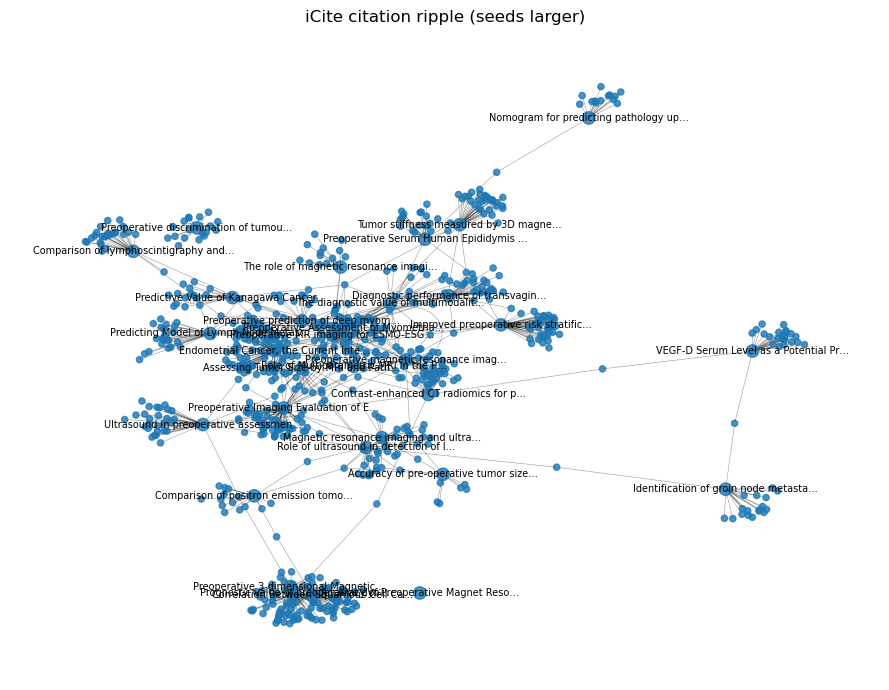

Saved: /mnt/data/icite_nodes.csv, icite_edges_directed.csv, icite_edges_undirected.csv


In [5]:
# %% [ICITE TEACHING DEMO] Build/inspect citation ripples with iCite (PubMed-only), with rich logging.
#
# What you get:
# - Robust iCite client: /api/pubs?pmids=...&legacy=false in 1,000-ID batches (documented max).
# - Clean, explicit logging (per-batch and per-cluster).
# - Construction of a citation network around your "seed" PMIDs (from your clustering run).
# - Deduped directed and undirected edges; ripple fanout and depth control.
# - A quick network plot (networkx + matplotlib). No seaborn, no styles.
#
# Expected upstream variables (preferred, but optional):
#   pmids  : List[str or int]      -> all PMIDs you fetched in the clustering notebook
#   titles : List[str]             -> same length as pmids
#   labels : np.ndarray or list    -> cluster labels from HDBSCAN; same length as pmids
#
# Fallback if not available: small ESearch on PubMed with your prior query to get ~60 PMIDs.

import os, sys, math, time, json, textwrap, re
from collections import defaultdict, Counter

import requests
import numpy as np
import pandas as pd

# Optional plotting (no seaborn, no styles)
import matplotlib.pyplot as plt
try:
    import networkx as nx
    _HAS_NX = True
except Exception:
    _HAS_NX = False

# ------------- CONFIG -------------
ICITE_BASE             = "https://icite.od.nih.gov/api/pubs"
ICITE_BATCH            = 1000     # iCite docs: max allowed per request
ICITE_LEGACY_FALSE     = True     # use actual DB field names (e.g., citedPmids)
ICITE_FIELDS           = None     # e.g., "pmid,pubYear,title,citedPmids,citedByPmids" to slim payload

# Ripple controls
MAX_UPSTREAM_PER_SEED  = 300      # caps fan-out per seed on references
MAX_DOWNSTREAM_PER_SEED= 300      # caps fan-out per seed on citers
DEPTH                  = 1        # depth 1 = seeds ±1 step; set 2 to ripple again (careful with growth)

# Logging verbosity: 0=quiet, 1=high-level, 2=debug
VERBOSE                = 2

# Fallback PubMed query (same thematic scope you used)
QUERY = (
    r'("Preanesthetic Evaluation"[Mesh] OR "Preoperative Care"[Mesh] '
    r'OR preanesthetic*[tiab] OR pre-anesthetic*[tiab] '
    r'OR "preoperative assessment"[tiab] OR "preoperative evaluation"[tiab] '
    r'OR "anesthetic assessment"[tiab] OR "anesthetic evaluation"[tiab]) '
    r'AND '
    r'("Pregnancy"[Mesh] OR "Pregnant Women"[Mesh] OR pregnan*[tiab] '
    r'OR gestation[tiab] OR obstetric*[tiab])'
)

# ------------- LOGGING -------------
def LOG(level:int, msg:str):
    if VERBOSE >= level:
        print(msg)

# ------------- UTILITIES -------------
def _to_int_list(val):
    if not val:
        return []
    if isinstance(val, list):
        return [int(x) for x in val if str(x).isdigit()]
    # Some odd responses can be singletons
    if isinstance(val, (int, str)) and str(val).isdigit():
        return [int(val)]
    return []

# ------------- ICITE CLIENT -------------
def icite_fetch(pmids, fields=ICITE_FIELDS, legacy_false=ICITE_LEGACY_FALSE, batch=ICITE_BATCH, tag="iCite"):
    """
    Fetch iCite records for a list of PMIDs.
    - Uses /api/pubs?pmids=...
    - Respects 1,000-ID per request limit (documented).
    - Returns dict: pmid -> {"citedPmids":[...], "citedByPmids":[...], ...}
    Logging: items=X | empty refs=Y | empty cited_by=Z
    """
    pmids = [int(p) for p in pmids if str(p).isdigit()]
    if not pmids:
        LOG(1, f"[{tag}] no input PMIDs")
        return {}

    result = {}
    total, empty_refs, empty_cby = 0, 0, 0

    for i in range(0, len(pmids), batch):
        chunk = pmids[i:i+batch]
        params = {"pmids": ",".join(str(p) for p in chunk)}
        if legacy_false:
            params["legacy"] = "false"
        if fields:
            params["fl"] = fields  # e.g., "pmid,pubYear,title,citedPmids,citedByPmids"

        url = ICITE_BASE
        r = requests.get(url, params=params, timeout=90)
        r.raise_for_status()

        data = r.json()
        # The API returns either {"data":[...]} or a plain list (depending on context)
        recs = data.get("data", data if isinstance(data, list) else [])
        for rec in recs:
            pid = rec.get("pmid")
            if pid is None or not str(pid).isdigit():
                continue
            pid = int(pid)
            # With legacy=false the field names are citedPmids / citedByPmids (documented)
            refs = _to_int_list(rec.get("citedPmids"))
            cby  = _to_int_list(rec.get("citedByPmids"))
            result[pid] = {"raw": rec, "citedPmids": refs, "citedByPmids": cby}
            total += 1
            if not refs: empty_refs += 1
            if not cby:  empty_cby += 1

        LOG(1, f"[{tag}] batch {i//batch+1}/{math.ceil(len(pmids)/batch)} size={len(chunk)} "
               f"| items={len(recs)} | empty refs={empty_refs} | empty cited_by={empty_cby}")

    LOG(1, f"[{tag}] DONE | items={total} | empty refs={empty_refs} | empty cited_by={empty_cby}")
    return result

# ------------- PUBMED FALLBACK (optional, if your pmids/labels aren't in memory) -------------
def pubmed_esearch(query, retmax=60):
    params = {
        "db": "pubmed",
        "term": query,
        "retmax": str(retmax),
        "sort": "pub+date",
        "retmode": "json"
    }
    r = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", params=params, timeout=60)
    r.raise_for_status()
    js = r.json()
    ids = js.get("esearchresult", {}).get("idlist", [])
    LOG(1, f"[ESearch] retrieved {len(ids)} PMIDs (demo fallback)")
    return [int(x) for x in ids if str(x).isdigit()]

# ------------- RIPPLE GRAPH CONSTRUCTION -------------
def build_ripple(seed_pmids, depth=1, cap_up=MAX_UPSTREAM_PER_SEED, cap_down=MAX_DOWNSTREAM_PER_SEED):
    """
    Build a citation network around seed_pmids.
    Directed edges:
      - p -> q for each reference q in citedPmids(p)  (upstream)
      - q -> p for each citer    q in citedByPmids(p) (downstream)
    Returns:
      nodes: set of pmids
      edges_dir: set of (source, target)
      edges_und: set of undirected tuples (min, max) (for plotting / dedup)
      batches: simple telemetry list for logging
    """
    nodes = set(int(p) for p in seed_pmids)
    edges_dir, edges_und = set(), set()
    batches = []

    frontier = set(seed_pmids)
    visited = set()

    for d in range(1, depth+1):
        LOG(1, f"[ripple] depth {d}/{depth} | frontier={len(frontier)}")
        info = icite_fetch(frontier, tag=f"iCite/SEEDS(d{d})")
        new_neighbors = set()
        seeds_found = 0
        refs_added = 0
        cby_added  = 0

        for p in frontier:
            rec = info.get(int(p))
            if not rec:  # not in iCite (rare) or API hiccup
                continue
            seeds_found += 1

            refs = rec["citedPmids"][:cap_up] if cap_up else rec["citedPmids"]
            cby  = rec["citedByPmids"][:cap_down] if cap_down else rec["citedByPmids"]

            for q in refs:
                nodes.add(q)
                edges_dir.add((int(p), int(q)))  # p cites q
                edges_und.add(tuple(sorted((int(p), int(q)))))
            for q in cby:
                nodes.add(q)
                edges_dir.add((int(q), int(p)))  # q cites p
                edges_und.add(tuple(sorted((int(q), int(p)))))

            refs_added += len(refs)
            cby_added  += len(cby)
            new_neighbors.update(refs)
            new_neighbors.update(cby)

        batch_stats = {
            "depth": d,
            "frontier": len(frontier),
            "seeds_found_in_icite": seeds_found,
            "nodes_total": len(nodes),
            "edges_total_und": len(edges_und),
            "refs_added": refs_added,
            "citers_added": cby_added,
            "next_frontier": len(new_neighbors - visited - frontier)
        }
        batches.append(batch_stats)
        LOG(2, f"[ripple/d{d}] seeds_found={seeds_found} | nodes={len(nodes)} "
               f"| und_edges={len(edges_und)} | refs+citers={refs_added}+{cby_added}")

        visited.update(frontier)
        frontier = (new_neighbors - visited)  # expand one ring out

    return nodes, edges_dir, edges_und, batches

# ------------- GRAPH SUMMARY & PLOTTING -------------
def summarize_graph(seed_pmids, nodes, edges_dir, edges_und):
    deg = defaultdict(int)
    for a,b in edges_und:
        deg[a]+=1; deg[b]+=1
    seeds = set(seed_pmids)
    seed_deg = [deg[s] for s in seeds]
    LOG(1, f"[graph] seeds={len(seeds)} | all_nodes={len(nodes)} | undirected_edges={len(edges_und)}")
    if seed_deg:
        LOG(1, f"[graph] seed degree: min={min(seed_deg)}, p50={np.median(seed_deg):.0f}, p90={np.percentile(seed_deg,90):.0f}, max={max(seed_deg)}")
    # Small table of top hubs
    top = sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:10]
    LOG(1, "[graph] top hubs (pmid, degree): " + ", ".join([f"{p}:{d}" for p,d in top]))
    return deg

def plot_graph(seed_pmids, nodes, edges_und, titles_by_pmid=None, max_nodes=800):
    if not _HAS_NX:
        LOG(1, "[plot] networkx not installed; skipping plot.")
        return
    if len(nodes) > max_nodes:
        LOG(1, f"[plot] graph too large ({len(nodes)} nodes) → sampling to {max_nodes}")
        # sample: keep all seeds + random subset of non-seeds
        seeds = set(seed_pmids)
        others = list(set(nodes) - seeds)
        keep_others = set(np.random.choice(others, size=max(0, max_nodes-len(seeds)), replace=False)) if len(others) > max_nodes - len(seeds) else set(others)
        keep = seeds | keep_others
        edges_und = {e for e in edges_und if e[0] in keep and e[1] in keep}
        nodes = keep

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges_und)

    # Node attributes
    seeds = set(seed_pmids)
    sizes = [80 if n in seeds else 20 for n in G.nodes()]
    labels = {}
    if titles_by_pmid:
        # Label only seeds to keep plot readable
        for s in seeds:
            t = titles_by_pmid.get(int(s), "")
            labels[int(s)] = (t[:36] + "…") if len(t) > 36 else t

    plt.figure(figsize=(9,7))
    pos = nx.spring_layout(G, seed=42, k=0.25)  # force-directed
    nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=0.4, alpha=0.4)
    if labels:
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)
    plt.title("iCite citation ripple (seeds larger)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ------------- DEMO DRIVER -------------
# Prefer existing pmids/titles/labels from your clustering notebook
try:
    SEED_PMIDS = [int(p) for p in pmids]
    TITLES_BY_PMID = {int(p): t for p,t in zip(pmids, titles)}
    LOG(1, f"[setup] using existing pmids from your clustering run: N={len(SEED_PMIDS)}")
except Exception:
    LOG(1, "[setup] pmids/titles not found in memory → fallback to a small PubMed query (demo only).")
    SEED_PMIDS = pubmed_esearch(QUERY, retmax=60)
    TITLES_BY_PMID = {}

# Optionally allow slicing (e.g., only one cluster) if labels are present
try:
    labels  # check existence
    lab = np.array(labels)
    # Example: focus the largest non-noise cluster (for a crisp demo)
    from collections import Counter
    cts = Counter([int(x) for x in lab if x != -1])
    if cts:
        largest = max(cts, key=cts.get)
        mask = (lab == largest)
        SEED_PMIDS = [int(p) for i,p in enumerate(pmids) if mask[i]]
        TITLES_BY_PMID = {int(p): titles[i] for i,p in enumerate(pmids) if mask[i]}
        LOG(1, f"[setup] focusing cluster={largest} | seeds={len(SEED_PMIDS)}")
except Exception:
    pass

# Build the ripple
nodes, edges_dir, edges_und, batches = build_ripple(SEED_PMIDS, depth=DEPTH)
LOG(1, "\n=== Ripple telemetry (per depth) ===")
LOG(1, pd.DataFrame(batches).to_string(index=False))

# Summarize & plot
deg = summarize_graph(SEED_PMIDS, nodes, edges_dir, edges_und)
plot_graph(SEED_PMIDS, nodes, edges_und, titles_by_pmid=TITLES_BY_PMID, max_nodes=800)

# Save artifacts for inspection/sharing
os.makedirs("/mnt/data", exist_ok=True)
pd.DataFrame(sorted(list(nodes)), columns=["pmid"]).to_csv("/mnt/data/icite_nodes.csv", index=False)
pd.DataFrame(list(edges_dir), columns=["src","dst"]).to_csv("/mnt/data/icite_edges_directed.csv", index=False)
pd.DataFrame(list(edges_und), columns=["a","b"]).to_csv("/mnt/data/icite_edges_undirected.csv", index=False)
LOG(1, "Saved: /mnt/data/icite_nodes.csv, icite_edges_directed.csv, icite_edges_undirected.csv")
